# Utility Methods

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

def show_images(images, per_row=2, titles=None, main_title=None, cmap=None, figsize=(48,18)):
    figure = plt.figure(1)
    for n, img in enumerate(images):
        columns = int(np.ceil(len(images) / per_row))
        ax = figure.add_subplot(columns, per_row, n + 1)

        
        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        if (titles is not None and len(titles) >= n):
            ax.set_title(titles[n])
        
        if cmap is None:
            ax.imshow(img)
        else:
            ax.imshow(img, cmap=cmap)
    if main_title is not None:
        plt.suptitle(main_title)
        
    figure.tight_layout()
    plt.show()    
    
def combine_images(img1, img2, padding=0):
    """
    Combines two images side-by-side.
    """
    height1,width1 = img1.shape[:2]
    height2,width2 = img2.shape[:2]

    new_width = width1+width2+padding
    new_height = np.max([height1, height2])

    combined_img = np.zeros(shape=(new_height, new_width, 3), dtype=np.uint8)
    combined_img[:height1,:width1]=img1
    combined_img[:height2,width1+padding:new_width]=img2
    return combined_img

def scale_to_uint8(arr):
    '''Rescales array to uint8'''
    scale_factor = np.max(arr) / 255
    return (arr / scale_factor).astype(np.uint8)


def binary_encode(grad, min_thresh, max_thresh):
    '''Encodes a 1 for values in the array that fall within threshold, 0 everywhere else'''
    binary_output = np.zeros_like(grad)
    binary_output[(grad >= min_thresh) & (grad <= max_thresh)] = 1
    return binary_output

def y_linespace(img):
    img_height = img.shape[0]
    return np.linspace(0, img_height-1, img_height)


# Camera Calibration

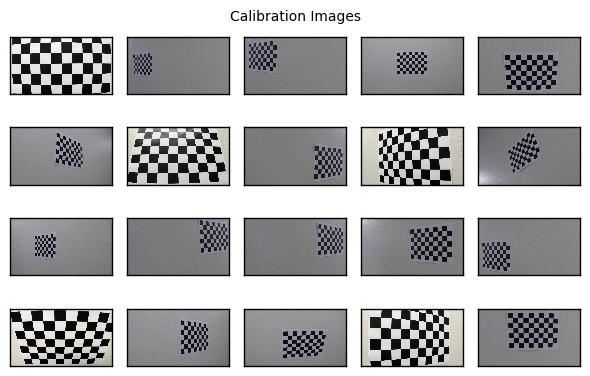

In [2]:

def load_camera_calibration_images():
    '''Loads the 20 camera calibration images'''
    
    imgs = {}
    directory = "camera_cal/"
    for i in range(1,21):
        filename = "calibration"+ str(i) + ".jpg"
        img = cv2.imread(directory + filename)
        imgs[filename] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    return imgs
    
calibration_imgs = load_camera_calibration_images()
corner_counts = (9, 6) # inside corners in row, column

show_images(calibration_imgs.values(), per_row=5, main_title="Calibration Images")

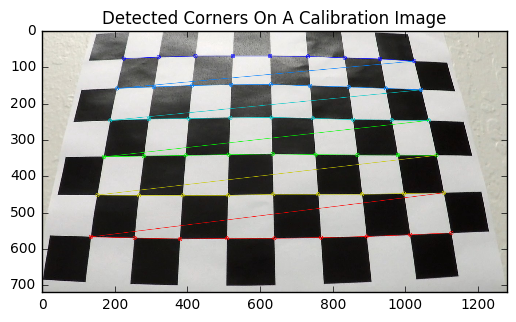

In [3]:
def find_and_show_corners(img, corner_counts):
    '''Finds corners in chessboard image and draws them on image'''
    new_img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,corner_counts, None)
    if ret == True:
        cv2.drawChessboardCorners(new_img, corner_counts, corners, ret)
        
    return new_img

# show calibration image with corners detected
img = find_and_show_corners(calibration_imgs['calibration3.jpg'], corner_counts)
plt.imshow(img)
plt.title("Detected Corners On A Calibration Image")
plt.show()

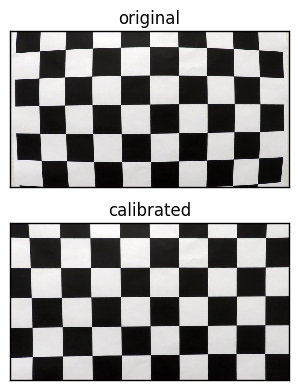

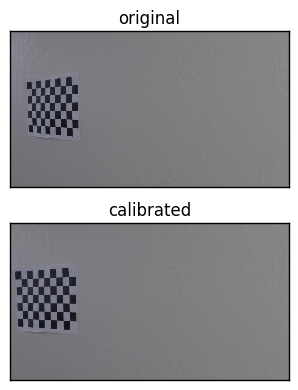

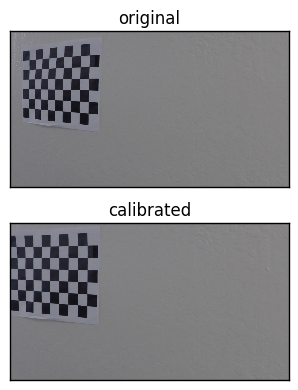

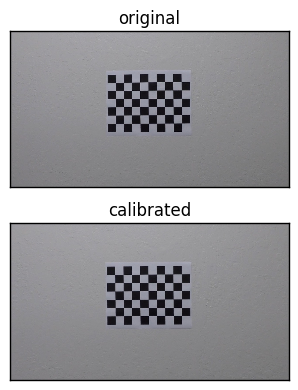

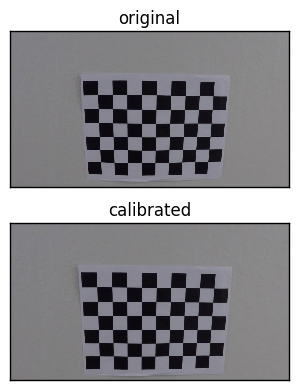

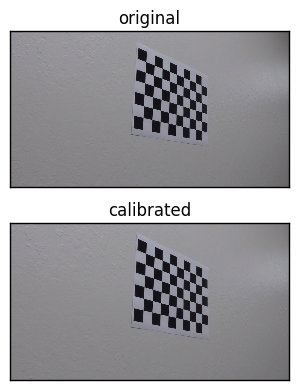

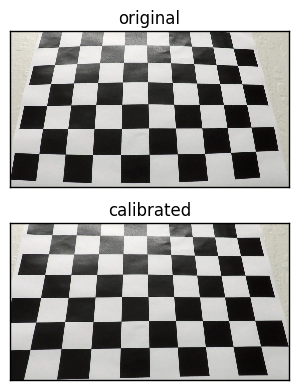

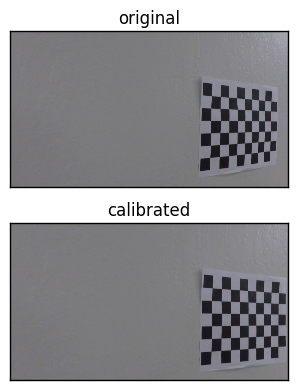

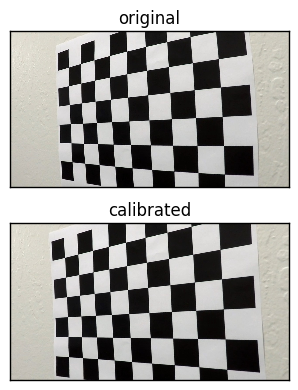

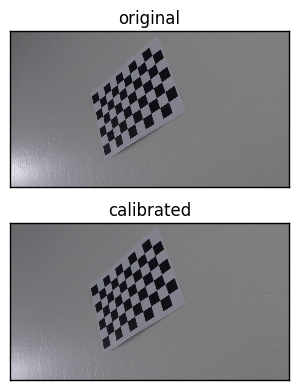

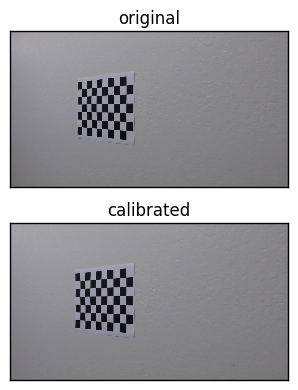

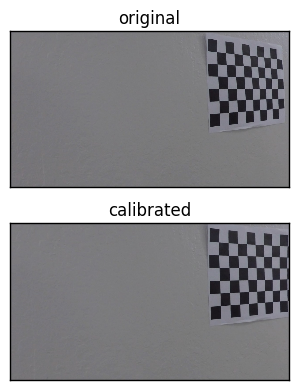

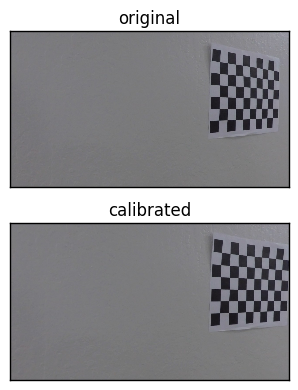

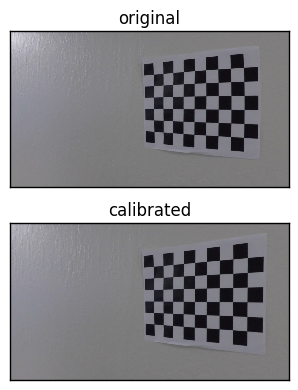

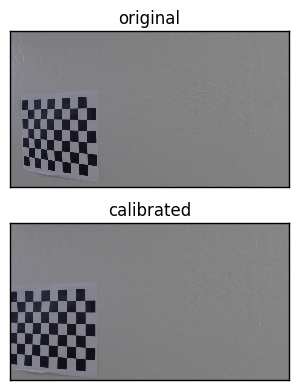

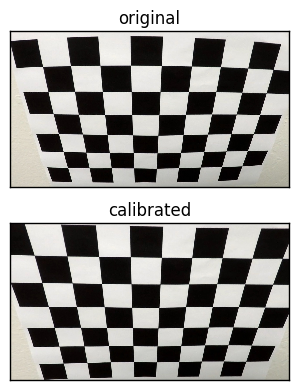

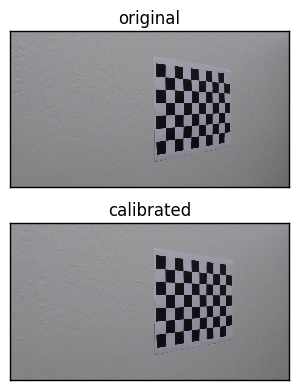

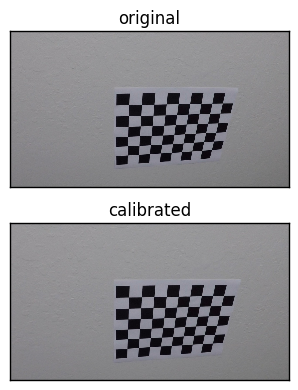

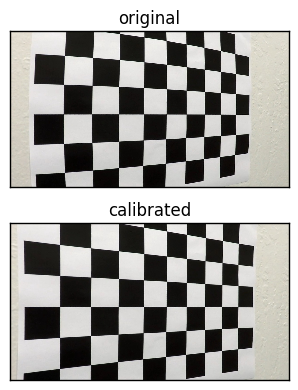

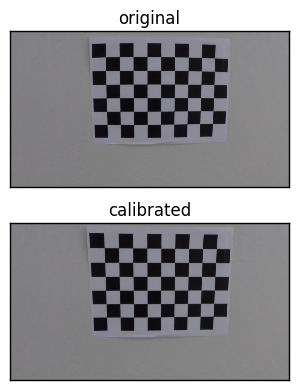

In [4]:
def calibrate_camera(calibration_imgs, corner_counts, use_pickle=True):
    '''Calibrate camera using calibration images or pickle file'''
    pickle_filename = 'camera_calibration.p'
    
     # use pickeled file, if it exists
    if use_pickle:
        try:
            saved_calibration = pickle.load(open(pickle_filename, 'rb'))
            return saved_calibration['mtx'], saved_calibration['dist']
        except(OSError, IOError) as e:
            print("Failed to open saved camera calibration...recalibrating")
        
    # Arrays to store points from all images
    object_pts = [] # Store 3D points for real world space
    image_pts = [] # 2D points from the image

    gray = None
    corner_find_fails = 0
    
    nx = corner_counts[0]
    ny = corner_counts[1]
        
    for calibration_img in calibration_imgs:
        # prepare object points
        obj_pts = np.zeros((nx*ny, 3), np.float32)
        obj_pts[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

        # get grayscale image to extract corners
        gray = cv2.cvtColor(calibration_img, cv2.COLOR_RGB2GRAY)

        # find corners
        found, corners = cv2.findChessboardCorners(gray, corner_counts, None)

        # if corners found, add to object points and image points
        if found == True:
            image_pts.append(corners)
            object_pts.append(obj_pts)
        else:
            corner_find_fails += 1

    if(corner_find_fails > 0):
        print("Failed to find corners on", corner_find_fails, "images.")

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_pts, image_pts, gray.shape[::-1], None,None)
    
    # save calibration to pickle file
    with open(pickle_filename, 'wb') as file:
        pickle.dump({'mtx': mtx, 'dist': dist},file)
                    
    return mtx, dist

def undistort(img):
    mtx,dist=calibrate_camera(calibration_imgs, corner_counts)
    return cv2.undistort(img, mtx,dist, None, mtx)

camera_mtx, camera_dist = calibrate_camera(list(calibration_imgs.values()), corner_counts)

# calibrated_img = cv2.undistort(img, mtx,dist, None, mtx)
# show original versus calibrated images
for key, img in calibration_imgs.items():
    corrected_img = undistort(img)
    cv2.imwrite('output_images/camera_cal/calibrated_'+key, corrected_img)
    show_images([img, corrected_img], titles=["original", "calibrated"], per_row=1)


In [5]:
def load_and_undistort(img_path):
    '''Loads and undistorts an image at provided path according to predetermined camera calibration matrix'''
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return undistort(img)

def load_test_images():
    test_img_filenames = glob.glob('test_images/*.jpg')
    rgb_images = []

    for filename in test_img_filenames:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rgb_images.append(undistort(img))
    
    return rgb_images


# Gradients

In [6]:
def to_single_channel_img(img):
    if len(img.shape) > 2 and img.shape[2] > 1:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        return img
    

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Calculates the directional gradient and returns a binary encoded result for the given threshold'''
    image = to_single_channel_img(img)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    abs_sobel = scale_to_uint8(abs_sobel)

    return binary_encode(abs_sobel, thresh[0], thresh[1])

def mag_threshold(image, sobel_kernel=3, thresh=(0, 255)):
    '''Calculates the gradient magnitude and returns a binary encoded result for the given threshold'''
    image = to_single_channel_img(img)

    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradient_magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    gradient_magnitude = scale_to_uint8(gradient_magnitude)

    return binary_encode(gradient_magnitude, thresh[0], thresh[1])


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi / 2)):
    '''Calculates the gradient direction and returns a binary encoded result for the given threshold'''
    image = to_single_channel_img(img)

    abs_sobelx = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    return binary_encode(absgraddir, thresh[0], thresh[1])


# Thresholding

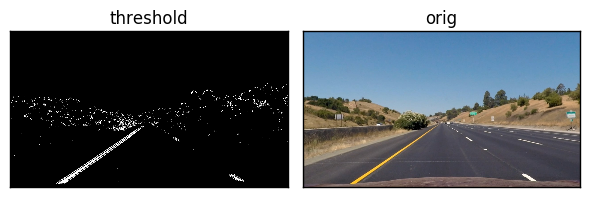

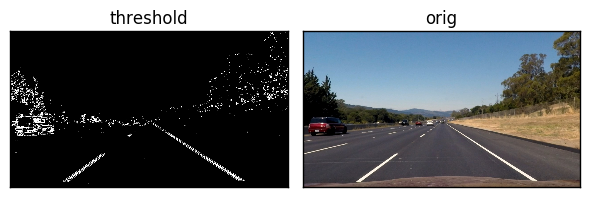

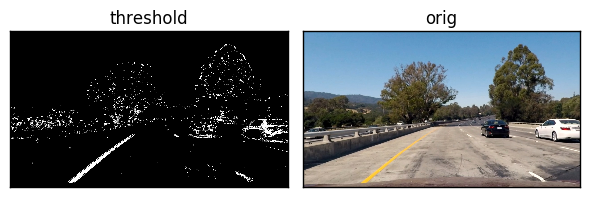

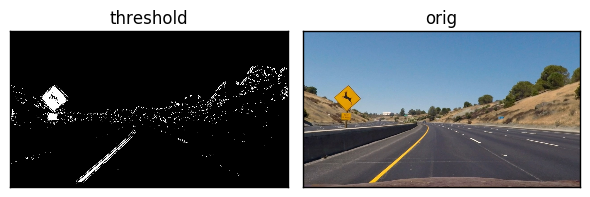

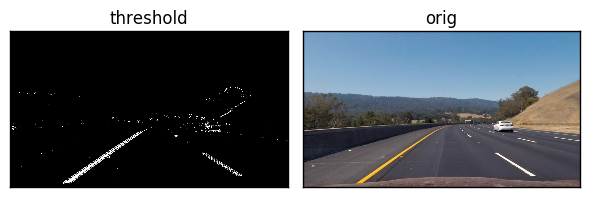

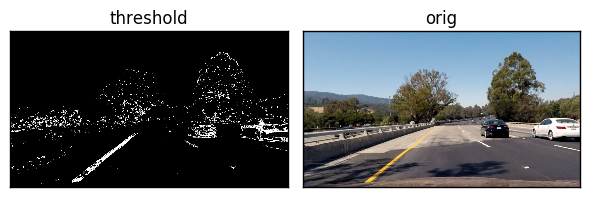

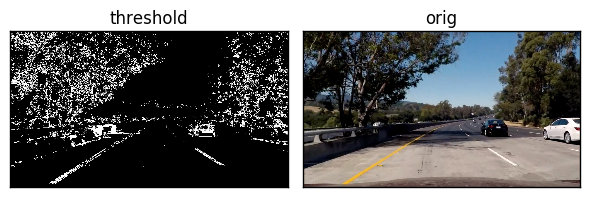

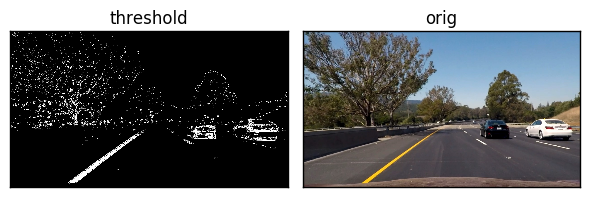

In [21]:

# def threshold_pipeline(img, s_thresh=(210,255),  s_channel=2,
#                        sx_thresh=(40,105), sy_thresh=(30,100), sx_channel=2, sx_kernel=15,
#                        dir_thresh=(0.8,1.1), dir_kernel=15,
#                        mag_thresh=(45,105), mag_kernel=9):
def threshold_pipeline(img, s_thresh=(210,255),  s_channel=2,
                       sx_thresh=(35,105), sy_thresh=(20,110), sx_channel=2, sx_kernel=15,
                       dir_thresh=(0.7,1.2), dir_kernel=15,
                       mag_thresh=(35,115), mag_kernel=9):
    img = np.copy(img)
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)

    sx_img = hls_img[:,:,sx_channel]
    s_img = hls_img[:,:,s_channel]
    sat_img = hls_img[:,:,2]

    sxbinary = abs_sobel_thresh(sx_img, thresh=sx_thresh, sobel_kernel=sx_kernel, orient='x')
    sybinary = abs_sobel_thresh(sx_img, thresh=sy_thresh, sobel_kernel=sx_kernel, orient='y')



    # binary encode color channel according to threshold
    s_binary = binary_encode(s_img, min_thresh=s_thresh[0], max_thresh=s_thresh[1])
    
    dir_binary = dir_threshold(sat_img, sobel_kernel=dir_kernel, thresh=dir_thresh)
    mag_binary = mag_threshold(sat_img, sobel_kernel=mag_kernel, thresh=mag_thresh)

    
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) & (sybinary == 1)) | ((dir_binary == 1) & (mag_binary == 1)) | (s_binary == 1)] = 1
    return combined

    #todo, apply mask here instead?
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    return color_binary

test_imgs = load_test_images()
for img in test_imgs:
    current = threshold_pipeline(img, s_thresh=(210,255), s_channel=2,
                                 sx_thresh=(45,105), sx_channel=2, sx_kernel=15,
                                dir_thresh=(0.8,1.1), dir_kernel=15,
                                mag_thresh=(45,105))
    
    prev = threshold_pipeline(img, s_thresh=(210,255), s_channel=2,
                                 sx_thresh=(40,110), sx_channel=2, sx_kernel=15)
    
    show_images(images=[current, img], titles=['threshold','orig'], per_row=2, cmap='gray')
    
    




# Perspective Transform

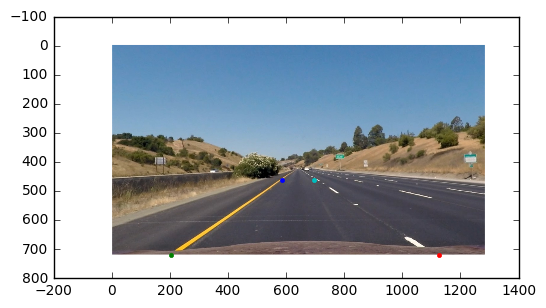

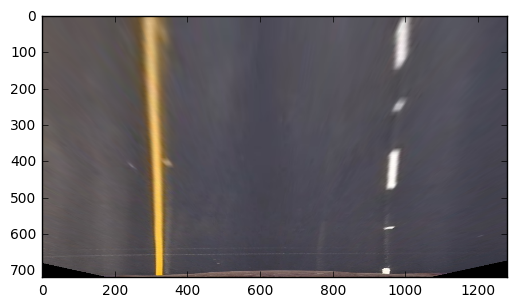

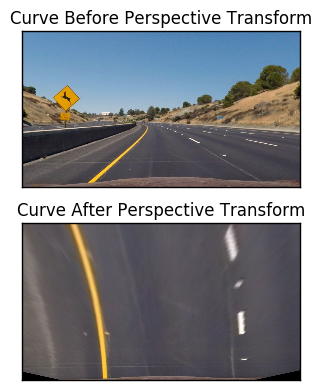

In [22]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = undistort(img)


def perspective_warp(img):
    '''Warps image using src, dest points to perform the transform'''
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
    [[586,460],
    [203,720],
    [1127, 720],
    [695, 460]]
    )
        
    dest = np.float32(
    [[320 ,0],
     [320,720],
     [960, 720],
     [960,0]
    ])

    
#     src = np.float32([[220,719],[1220,719],[750,480],[550,480]])
#     # define 4 destination points for perspective transformation
#     dest = np.float32([[240,719],[1040,719],[1040,300],[240,300]])
    
    M = cv2.getPerspectiveTransform(src,dest)
    
    Minv = cv2.getPerspectiveTransform(dest,src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.plot(585,460,".") # top right
plt.plot(203,720,".") # bottom right
plt.plot(1127,720,".") # top left
plt.plot(695,460,".") # bottom left
plt.show()

plt.imshow(perspective_warp(img)[0])
plt.show()

test2 = load_and_undistort('test_images/test2.jpg')
warped_test2 = perspective_warp(test2)[0]

show_images([test2, warped_test2], per_row=1, 
            titles=["Curve Before Perspective Transform","Curve After Perspective Transform"])

# Perspective With Thresholding

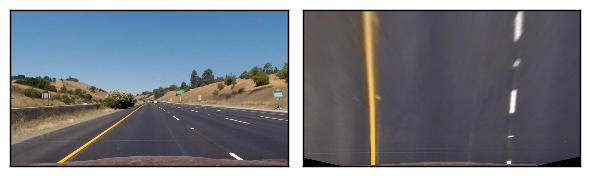

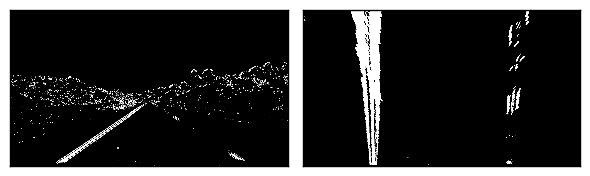

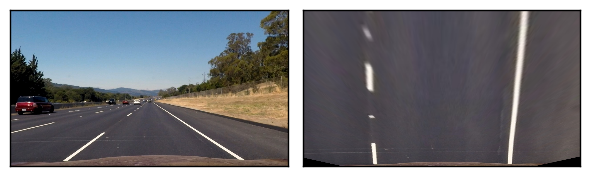

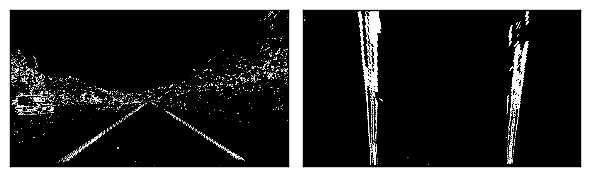

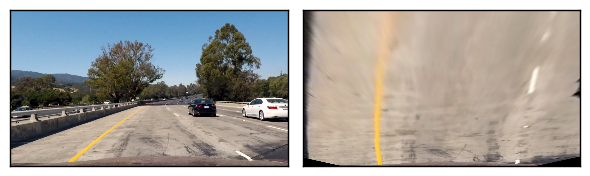

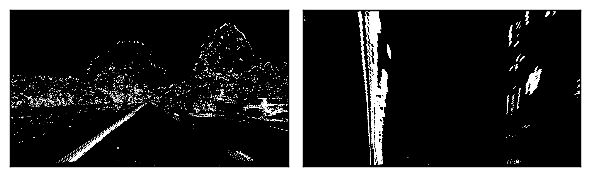

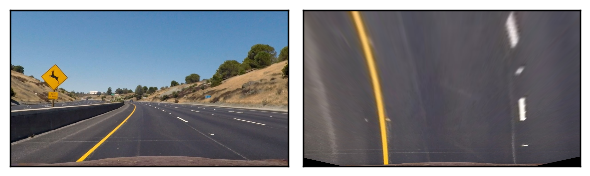

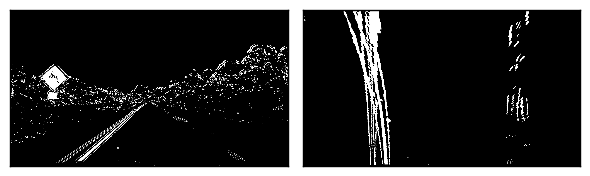

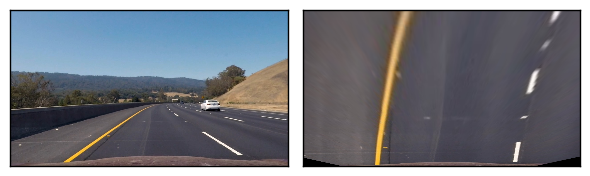

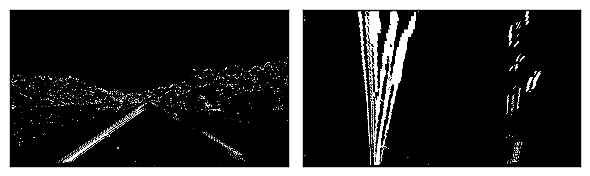

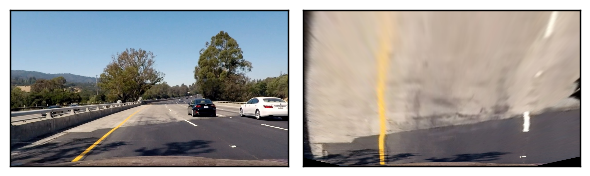

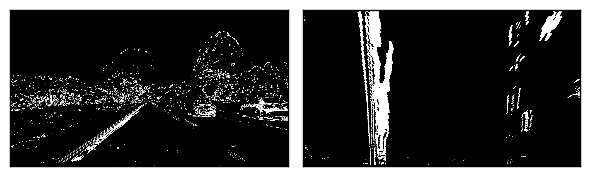

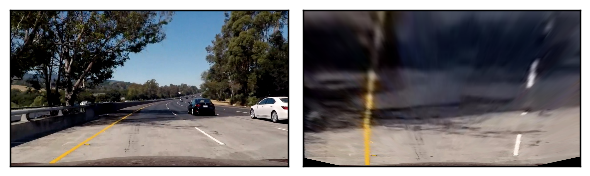

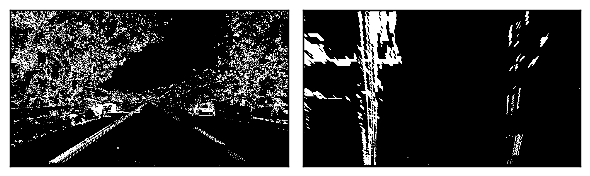

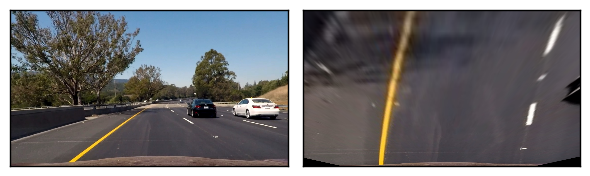

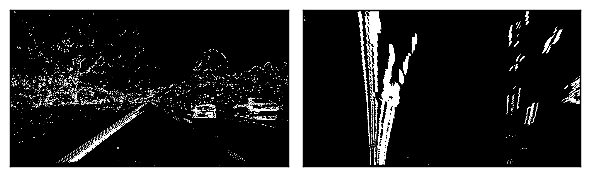

In [23]:
test_imgs = load_test_images()

for image in test_imgs:
    threshold = threshold_pipeline(image)
    
    threshold_warped = perspective_warp(threshold)[0]
    img_warped = perspective_warp(image)[0]
    
    show_images(images=[image, img_warped], per_row=2)
    show_images([threshold, threshold_warped], per_row=2, cmap='gray')
    

# Finding Lines

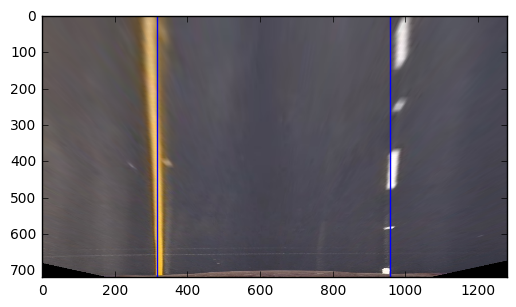

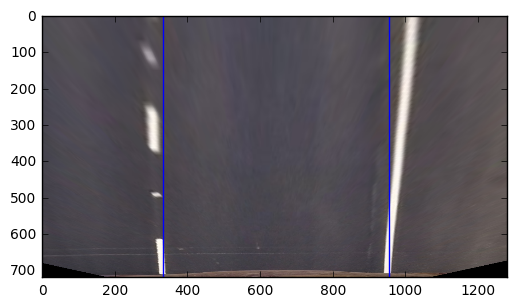

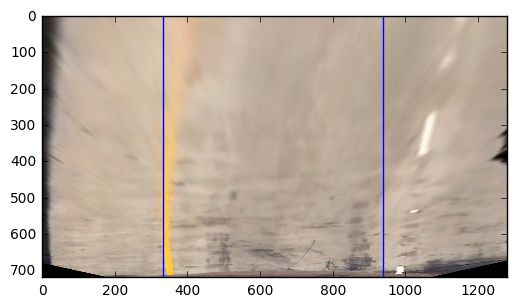

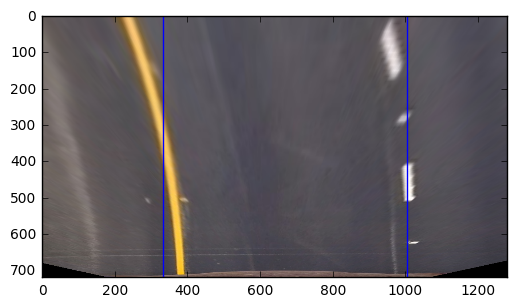

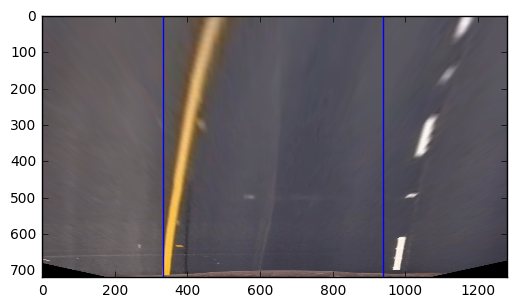

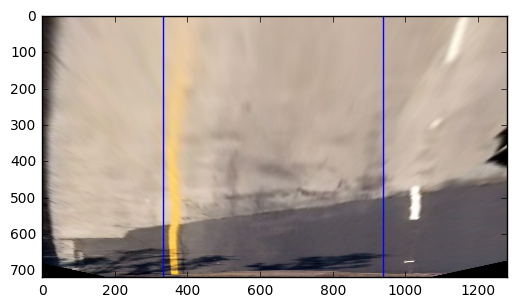

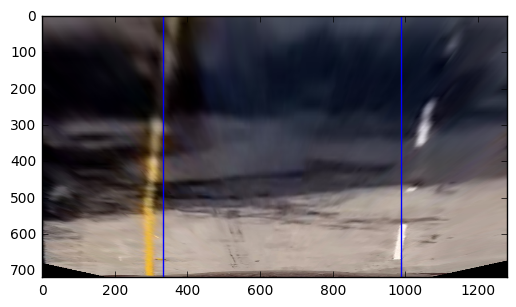

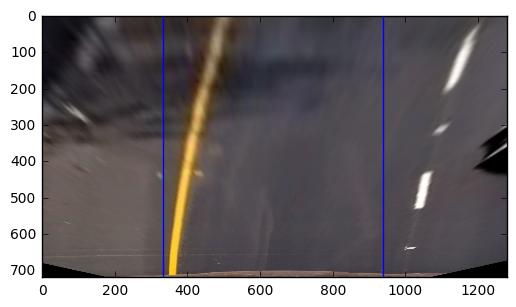

In [24]:
def detect_line_bases(warped_img):
    lower_half = int(warped_img.shape[0]/2)
    histogram = np.sum(warped_img[lower_half:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_base, right_base

test_imgs = load_test_images()

for image in test_imgs:
    threshold = threshold_pipeline(image)
    warped_img = perspective_warp(threshold)[0]
    
    plt.imshow(perspective_warp(image)[0], cmap='gray')
    left_base, right_base = detect_line_bases(warped_img)
    
    plt.axvline(x=left_base)
    plt.axvline(x=right_base)
    plt.show()

    

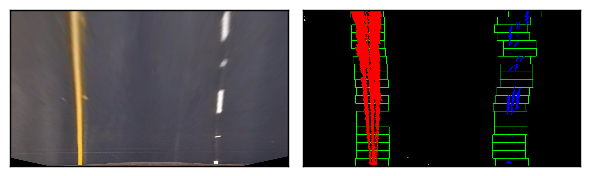

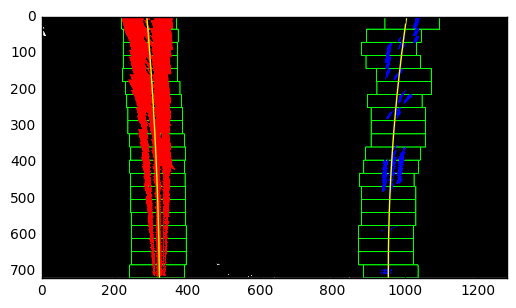

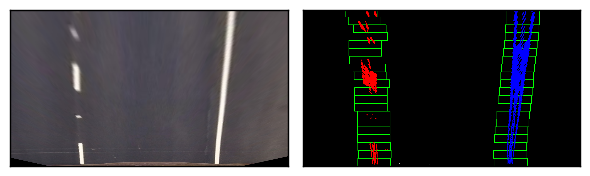

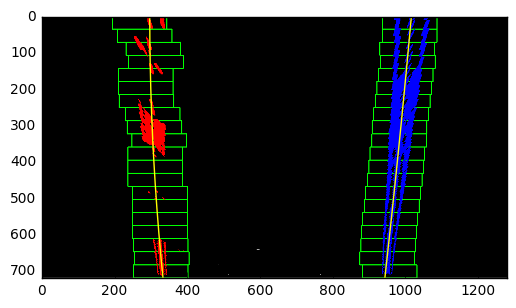

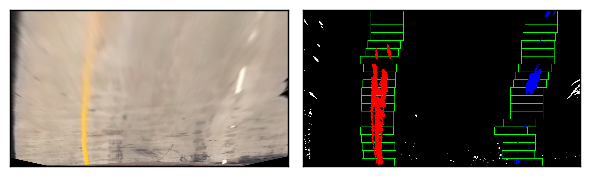

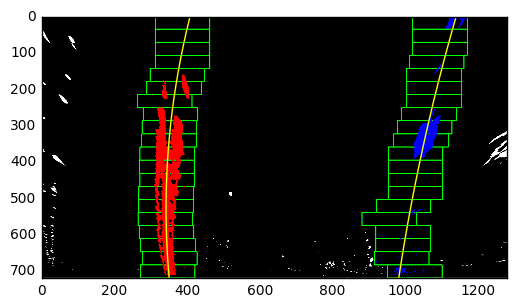

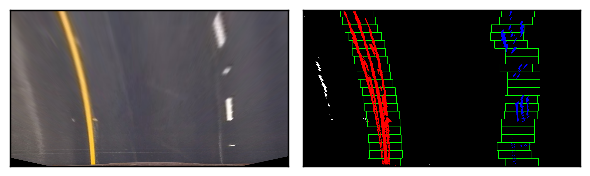

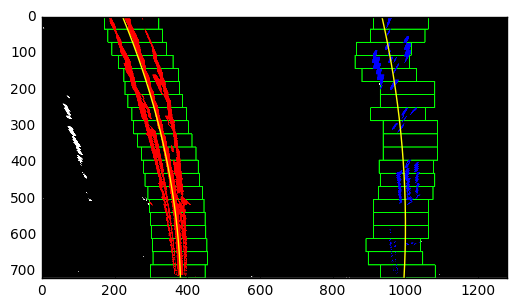

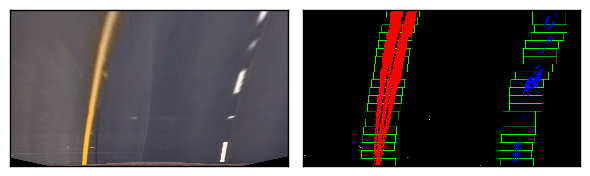

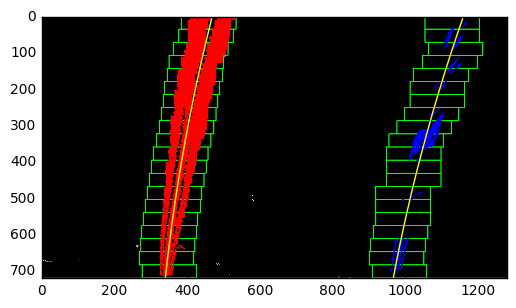

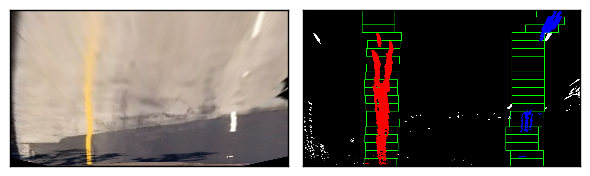

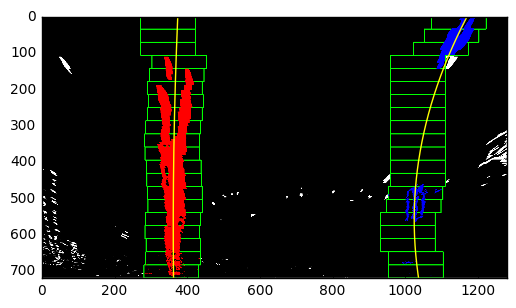

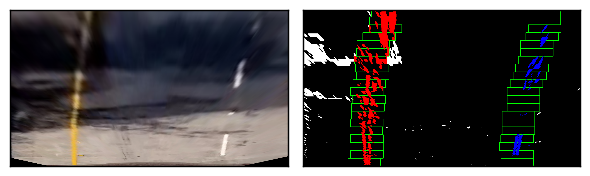

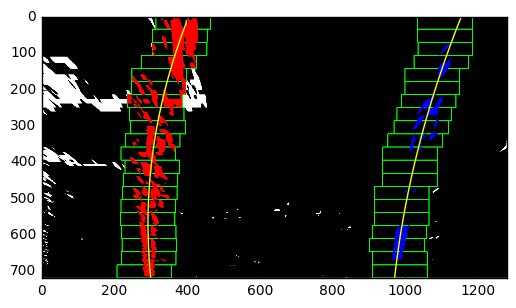

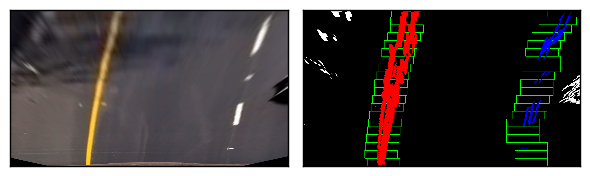

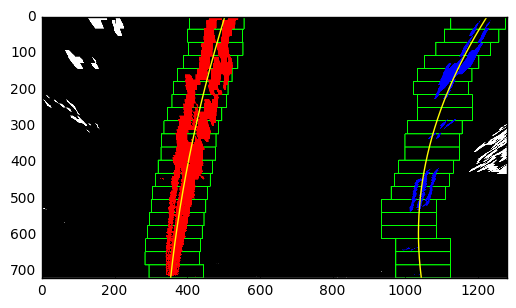

In [33]:
def detect_lanes(warped_img):
    out_img = np.dstack((warped_img, warped_img, warped_img)) * 255
    left_base, right_base = detect_line_bases(warped_img)
    
    window_count = 20
    window_width = 75
    min_pixels_to_recenter = 40
    
    img_height = warped_img.shape[0]
    window_height = np.int(img_height / window_count)
    
    # get x,y position of all nonzero pixels in image
    nonzero = warped_img.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    current_left_x = left_base
    current_right_x = right_base
    
    # lists for left/right lane indices
    left_lane_indices = []
    right_lane_indices = []
    
    # iterate through windows
    for window in range(window_count):
        # set boundaries for windows
        window_y_low = img_height - (window+1) * window_height
        window_y_high = img_height - (window * window_height)
        
        window_x_left_low = current_left_x - window_width
        window_x_left_high = current_left_x + window_width
        
        window_x_right_low = current_right_x - window_width
        window_x_right_high = current_right_x + window_width
        
        # draw windows
        out_img = cv2.rectangle(out_img,(window_x_left_low,window_y_low),(window_x_left_high,window_y_high),(0,255,0), 2) 
        out_img = cv2.rectangle(out_img,(window_x_right_low,window_y_low),(window_x_right_high,window_y_high),(0,255,0), 2) 
        
        # get nonzeros within the left and right windows
        nonzeros_in_left_window = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) &
                                  (nonzero_x >= window_x_left_low) & (nonzero_x < window_x_left_high)).nonzero()[0]
        
        nonzeros_in_right_window = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) &
                                  (nonzero_x >= window_x_right_low) & (nonzero_x < window_x_right_high)).nonzero()[0]
        
        # add indices to lane lists
        left_lane_indices.append(nonzeros_in_left_window)
        right_lane_indices.append(nonzeros_in_right_window)
        
        # recenter if found pixels exceeds threshold
        if len(nonzeros_in_left_window) > min_pixels_to_recenter:
            current_left_x = np.int(np.mean(nonzero_x[nonzeros_in_left_window]))

        if len(nonzeros_in_right_window) > min_pixels_to_recenter:
            current_right_x = np.int(np.mean(nonzero_x[nonzeros_in_right_window]))
        
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    
    # get left/right lane positions
    leftx = nonzero_x[left_lane_indices]
    lefty = nonzero_y[left_lane_indices]
    rightx = nonzero_x[right_lane_indices]
    righty = nonzero_y[right_lane_indices]
    
    # use second order polynomial to fit each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # draw predicted lane line
    ploty = y_linespace(warped_img)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255,0,0]
    out_img[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]

    
    return {
                "squares_img": out_img, 
                "left_fitx": left_fitx, 
                "right_fitx": right_fitx, 
                "left_fit": left_fit,
                "right_fit": right_fit
           }

        
test_imgs = load_test_images()
for img in test_imgs:
    edited_img = threshold_pipeline(img)
    warped = perspective_warp(edited_img)[0]

    ret = detect_lanes(warped)

    squares, left_fitx, right_fitx = ret["squares_img"], ret["left_fitx"], ret["right_fitx"]

    show_images([perspective_warp(img)[0], squares])
    
    plt.imshow(squares)

    ploty = y_linespace(warped)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    

# Measuring Lane Curvature

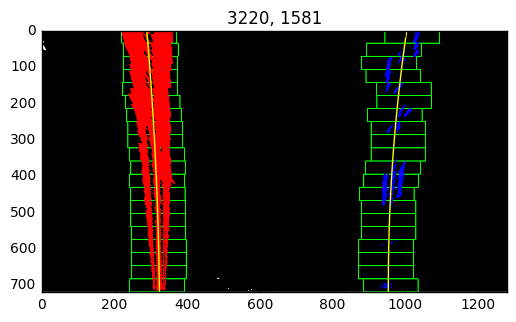

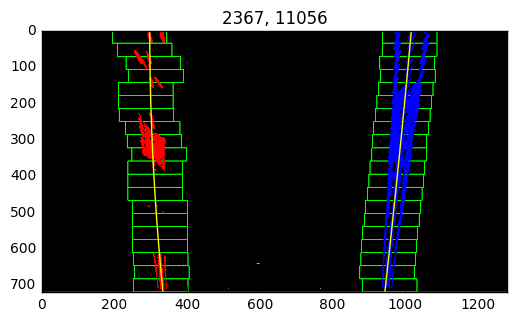

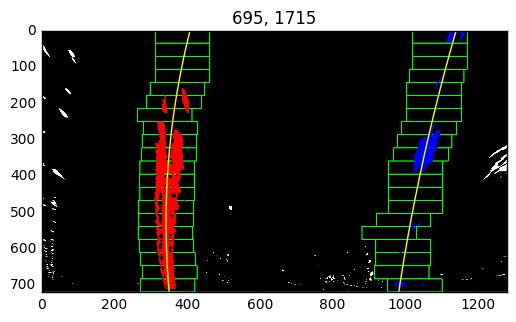

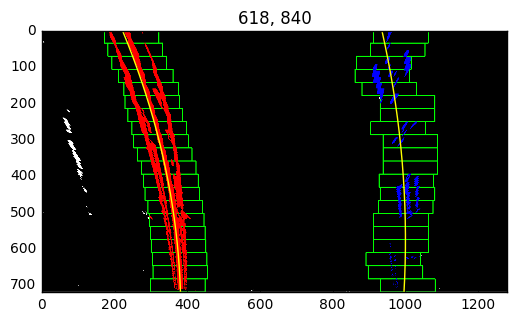

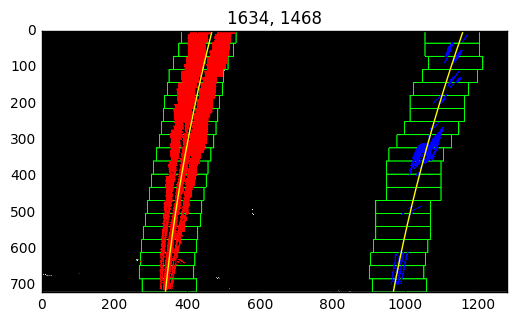

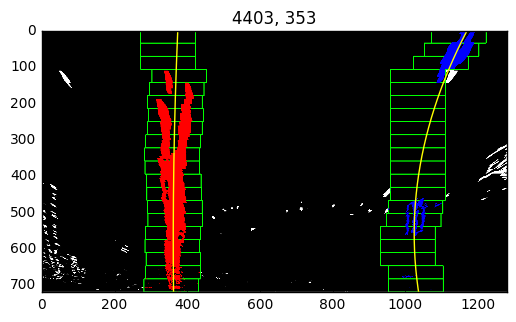

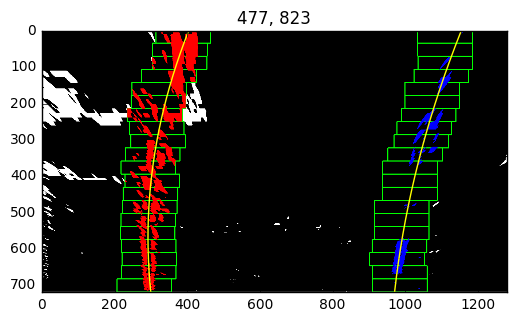

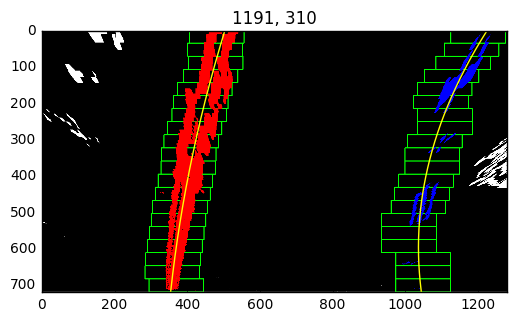

In [44]:
def estimate_lane_curvature(left_fitx, right_fitx, ploty, left_fit, right_fit):
    
    # define radius of curvature at bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # return radius of curvature is in meters
    return left_curverad, right_curverad


test_imgs = load_test_images()

for img in test_imgs:
    threshold_img = threshold_pipeline(img)
    warped_img = perspective_warp(threshold_img)[0]
    
    ret = detect_lanes(warped_img)
    
    ploty = y_linespace(warped_img)
    squares, left_fitx, right_fitx = ret["squares_img"], ret["left_fitx"], ret["right_fitx"]
    left_fit, right_fit = ret['left_fit'], ret['right_fit']
    
    left_curvature, right_curvature = estimate_lane_curvature(left_fitx=ret['left_fitx'],right_fitx=ret['right_fitx'], ploty=ploty,
                           left_fit=ret['left_fit'], right_fit=ret['right_fit'])
    
    plt.title('{0:.0f}, {1:.0f}'.format(left_curvature, right_curvature))
    plt.imshow(squares)
    ploty = y_linespace(warped)
    plt.plot(ret['left_fitx'], ploty, color='yellow')
    plt.plot(ret['right_fitx'], ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    plt.show()

# Show Lanes

In [46]:
def show_lanes(orig_img, warped_img, Minv, left_fitx, right_fitx):
    ploty = y_linespace(warped_img)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # recast x,y int format for fillPoly
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
   
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)

    return result


test_imgs = load_test_images()

for img in test_images:
    threshold_img = threshold_pipeline(img)
    warped_img, M, Minv = perspective_warp(threshold_img)
    
    ret = detect_lanes(warped_img)
    
    final_img = show_lanes(img, warped_img, Minv, ret['left_fitx'], ret['right_fitx'])
    
    plt.imshow(final_img)
    plt.show()
    

NameError: name 'test_images' is not defined

In [53]:


# combined = combine_images(load_and_undistort("test_images/test1.jpg"), 
#                          perspective_warp(load_and_undistort('test_images/test1.jpg')),
#                         padding=20)

last_left_fit = None
last_right_fit = None

def process_image(img):
    global last_left_fit
    global last_right_fit
    
    undistorted_img = undistort(img)
    threshold_img = threshold_pipeline(undistorted_img)
    warped_img, M, Minv = perspective_warp(threshold_img)
    
    ret = detect_lanes(warped_img)
    
    left_curvature, right_curvature = estimate_lane_curvature(left_fitx=ret['left_fitx'],right_fitx=ret['right_fitx'], ploty=ploty,
                   left_fit=ret['left_fit'], right_fit=ret['right_fit'])
    
    curr_left_fit, curr_right_fit = ret['left_fitx'], ret['right_fitx']

    
    # check for invalid estimates
    invalid_curvature = abs(left_curvature - right_curvature) > 7 * min(left_curvature, right_curvature)
    if invalid_curvature and (last_left_fit is not None and last_right_fit is not None):
        curr_left_fit, curr_right_fit = last_left_fit, last_right_fit
    
    final_img = show_lanes(undistorted_img, warped_img, Minv, curr_left_fit, curr_right_fit)
    
    last_left_fit, last_right_fit = curr_left_fit, curr_right_fit
    return final_img



clip1 = VideoFileClip('project_video.mp4')
combined_clip = clip1.fl_image(process_image)
%time combined_clip.write_videofile("combined.mp4", audio=False)


[MoviePy] >>>> Building video combined.mp4
[MoviePy] Writing video combined.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<06:37,  3.17it/s]


  0%|          | 2/1261 [00:00<06:45,  3.10it/s]


  0%|          | 3/1261 [00:00<06:43,  3.12it/s]


  0%|          | 4/1261 [00:01<06:39,  3.15it/s]


  0%|          | 5/1261 [00:01<06:36,  3.17it/s]


  0%|          | 6/1261 [00:01<06:35,  3.17it/s]


  1%|          | 7/1261 [00:02<06:33,  3.19it/s]


  1%|          | 8/1261 [00:02<06:31,  3.20it/s]


  1%|          | 9/1261 [00:02<06:27,  3.23it/s]


  1%|          | 10/1261 [00:03<06:25,  3.25it/s]


  1%|          | 11/1261 [00:03<06:21,  3.28it/s]


  1%|          | 12/1261 [00:03<06:21,  3.27it/s]


  1%|          | 13/1261 [00:04<06:18,  3.29it/s]


  1%|          | 14/1261 [00:04<06:14,  3.33it/s]


  1%|          | 15/1261 [00:04<06:14,  3.33it/s]


  1%|▏         | 16/1261 [00:04<06:15,  3.31it/s]


  1%|▏         | 17/1261 [00:05<06:16,  3.31it/s]


  1%|▏         | 18/1261 [00:05<06:20,  3.27it/s]


  2%|▏         | 19/1261 [0

invalid frame detected





  6%|▌         | 77/1261 [00:24<06:18,  3.13it/s]


  6%|▌         | 78/1261 [00:24<06:17,  3.13it/s]


  6%|▋         | 79/1261 [00:24<06:14,  3.15it/s]


  6%|▋         | 80/1261 [00:24<06:16,  3.14it/s]


  6%|▋         | 81/1261 [00:25<06:12,  3.17it/s]


  7%|▋         | 82/1261 [00:25<06:08,  3.20it/s]

invalid frame detected





  7%|▋         | 83/1261 [00:25<06:11,  3.17it/s]

invalid frame detected





  7%|▋         | 84/1261 [00:26<06:15,  3.14it/s]


  7%|▋         | 85/1261 [00:26<06:47,  2.89it/s]


  7%|▋         | 86/1261 [00:26<06:42,  2.92it/s]


  7%|▋         | 87/1261 [00:27<06:29,  3.01it/s]


  7%|▋         | 88/1261 [00:27<06:23,  3.06it/s]


  7%|▋         | 89/1261 [00:27<06:21,  3.07it/s]


  7%|▋         | 90/1261 [00:28<06:20,  3.08it/s]


  7%|▋         | 91/1261 [00:28<06:21,  3.06it/s]


  7%|▋         | 92/1261 [00:28<06:20,  3.07it/s]


  7%|▋         | 93/1261 [00:29<06:16,  3.11it/s]


  7%|▋         | 94/1261 [00:29<06:18,  3.09it/s]


  8%|▊         | 95/1261 [00:29<06:16,  3.10it/s]


  8%|▊         | 96/1261 [00:30<06:18,  3.08it/s]


  8%|▊         | 97/1261 [00:30<06:17,  3.08it/s]


  8%|▊         | 98/1261 [00:30<06:13,  3.11it/s]


  8%|▊         | 99/1261 [00:31<06:08,  3.15it/s]


  8%|▊         | 100/1261 [00:31<06:05,  3.18it/s]


  8%|▊         | 101/1261 [00:31<06:09,  3.14it/s]

invalid frame detected





  8%|▊         | 102/1261 [00:32<06:04,  3.18it/s]

invalid frame detected





  8%|▊         | 103/1261 [00:32<06:03,  3.18it/s]


  8%|▊         | 104/1261 [00:32<06:03,  3.19it/s]


  8%|▊         | 105/1261 [00:33<06:00,  3.20it/s]


  8%|▊         | 106/1261 [00:33<05:57,  3.23it/s]


  8%|▊         | 107/1261 [00:33<05:55,  3.25it/s]


  9%|▊         | 108/1261 [00:33<05:53,  3.26it/s]


  9%|▊         | 109/1261 [00:34<05:55,  3.24it/s]


  9%|▊         | 110/1261 [00:34<05:54,  3.25it/s]


  9%|▉         | 111/1261 [00:34<05:54,  3.25it/s]


  9%|▉         | 112/1261 [00:35<05:52,  3.26it/s]


  9%|▉         | 113/1261 [00:35<05:52,  3.26it/s]


  9%|▉         | 114/1261 [00:35<05:53,  3.25it/s]


  9%|▉         | 115/1261 [00:36<05:52,  3.25it/s]


  9%|▉         | 116/1261 [00:36<05:53,  3.23it/s]


  9%|▉         | 117/1261 [00:36<06:02,  3.16it/s]


  9%|▉         | 118/1261 [00:37<06:11,  3.08it/s]


  9%|▉         | 119/1261 [00:37<06:09,  3.09it/s]


 10%|▉         | 120/1261 [00:37<06:12,  3.06it/s]


 10%|▉         | 121/1261 [00:38<06:06,  3.

invalid frame detected





 18%|█▊        | 222/1261 [01:10<05:27,  3.17it/s]


 18%|█▊        | 223/1261 [01:11<05:24,  3.20it/s]


 18%|█▊        | 224/1261 [01:11<05:21,  3.22it/s]


 18%|█▊        | 225/1261 [01:11<05:24,  3.19it/s]


 18%|█▊        | 226/1261 [01:12<05:22,  3.21it/s]

invalid frame detected





 18%|█▊        | 227/1261 [01:12<05:26,  3.17it/s]


 18%|█▊        | 228/1261 [01:12<05:25,  3.17it/s]


 18%|█▊        | 229/1261 [01:13<05:27,  3.15it/s]


 18%|█▊        | 230/1261 [01:13<05:25,  3.16it/s]


 18%|█▊        | 231/1261 [01:13<05:26,  3.16it/s]


 18%|█▊        | 232/1261 [01:14<05:26,  3.16it/s]

invalid frame detected





 18%|█▊        | 233/1261 [01:14<05:31,  3.10it/s]

invalid frame detected





 19%|█▊        | 234/1261 [01:14<05:35,  3.06it/s]


 19%|█▊        | 235/1261 [01:15<05:35,  3.06it/s]


 19%|█▊        | 236/1261 [01:15<05:29,  3.11it/s]


 19%|█▉        | 237/1261 [01:15<05:32,  3.08it/s]

invalid frame detected





 19%|█▉        | 238/1261 [01:16<05:28,  3.11it/s]


 19%|█▉        | 239/1261 [01:16<05:22,  3.17it/s]

invalid frame detected





 19%|█▉        | 240/1261 [01:16<05:20,  3.19it/s]

invalid frame detected





 19%|█▉        | 241/1261 [01:16<05:35,  3.04it/s]


 19%|█▉        | 242/1261 [01:17<05:39,  3.00it/s]


 19%|█▉        | 243/1261 [01:17<05:44,  2.96it/s]


 19%|█▉        | 244/1261 [01:18<05:48,  2.92it/s]


 19%|█▉        | 245/1261 [01:18<05:45,  2.94it/s]


 20%|█▉        | 246/1261 [01:18<05:35,  3.02it/s]

invalid frame detected





 20%|█▉        | 247/1261 [01:18<05:28,  3.09it/s]


 20%|█▉        | 248/1261 [01:19<05:25,  3.11it/s]


 20%|█▉        | 249/1261 [01:19<05:21,  3.14it/s]


 20%|█▉        | 250/1261 [01:19<05:20,  3.16it/s]


 20%|█▉        | 251/1261 [01:20<05:19,  3.16it/s]


 20%|█▉        | 252/1261 [01:20<05:18,  3.16it/s]

invalid frame detected





 20%|██        | 253/1261 [01:20<05:15,  3.19it/s]

invalid frame detected





 20%|██        | 254/1261 [01:21<05:13,  3.21it/s]


 20%|██        | 255/1261 [01:21<05:13,  3.21it/s]


 20%|██        | 256/1261 [01:21<05:13,  3.21it/s]


 20%|██        | 257/1261 [01:22<05:10,  3.23it/s]


 20%|██        | 258/1261 [01:22<05:15,  3.18it/s]

invalid frame detected





 21%|██        | 259/1261 [01:22<05:13,  3.20it/s]


 21%|██        | 260/1261 [01:23<05:13,  3.20it/s]


 21%|██        | 261/1261 [01:23<05:12,  3.20it/s]


 21%|██        | 262/1261 [01:23<05:13,  3.18it/s]

invalid frame detected





 21%|██        | 263/1261 [01:23<05:12,  3.19it/s]

invalid frame detected





 21%|██        | 264/1261 [01:24<05:09,  3.22it/s]

invalid frame detected





 21%|██        | 265/1261 [01:24<05:12,  3.18it/s]


 21%|██        | 266/1261 [01:24<05:14,  3.16it/s]


 21%|██        | 267/1261 [01:25<05:14,  3.16it/s]


 21%|██▏       | 268/1261 [01:25<05:10,  3.20it/s]

invalid frame detected





 21%|██▏       | 269/1261 [01:25<05:09,  3.20it/s]

invalid frame detected





 21%|██▏       | 270/1261 [01:26<05:14,  3.15it/s]

invalid frame detected





 21%|██▏       | 271/1261 [01:26<05:23,  3.06it/s]


 22%|██▏       | 272/1261 [01:26<05:21,  3.07it/s]


 22%|██▏       | 273/1261 [01:27<05:18,  3.10it/s]


 22%|██▏       | 274/1261 [01:27<05:17,  3.10it/s]

invalid frame detected





 22%|██▏       | 275/1261 [01:27<05:12,  3.15it/s]


 22%|██▏       | 276/1261 [01:28<05:09,  3.18it/s]


 22%|██▏       | 277/1261 [01:28<05:07,  3.20it/s]


 22%|██▏       | 278/1261 [01:28<05:07,  3.20it/s]


 22%|██▏       | 279/1261 [01:29<05:05,  3.22it/s]

invalid frame detected





 22%|██▏       | 280/1261 [01:29<05:09,  3.17it/s]

invalid frame detected





 22%|██▏       | 281/1261 [01:29<05:10,  3.16it/s]

invalid frame detected





 22%|██▏       | 282/1261 [01:29<05:08,  3.17it/s]


 22%|██▏       | 283/1261 [01:30<05:07,  3.18it/s]


 23%|██▎       | 284/1261 [01:30<05:12,  3.13it/s]


 23%|██▎       | 285/1261 [01:30<05:13,  3.11it/s]


 23%|██▎       | 286/1261 [01:31<05:10,  3.14it/s]


 23%|██▎       | 287/1261 [01:31<05:06,  3.18it/s]


 23%|██▎       | 288/1261 [01:31<05:04,  3.20it/s]


 23%|██▎       | 289/1261 [01:32<05:03,  3.21it/s]


 23%|██▎       | 290/1261 [01:32<05:02,  3.21it/s]


 23%|██▎       | 291/1261 [01:32<05:02,  3.21it/s]


 23%|██▎       | 292/1261 [01:33<05:20,  3.02it/s]


 23%|██▎       | 293/1261 [01:33<05:45,  2.80it/s]


 23%|██▎       | 294/1261 [01:34<05:53,  2.73it/s]


 23%|██▎       | 295/1261 [01:34<05:41,  2.83it/s]


 23%|██▎       | 296/1261 [01:34<05:33,  2.89it/s]


 24%|██▎       | 297/1261 [01:34<05:27,  2.94it/s]


 24%|██▎       | 298/1261 [01:35<05:53,  2.72it/s]


 24%|██▎       | 299/1261 [01:35<05:43,  2.80it/s]


 24%|██▍       | 300/1261 [01:36<05:40,  2.

invalid frame detected





 25%|██▍       | 315/1261 [01:40<04:54,  3.21it/s]

invalid frame detected





 25%|██▌       | 316/1261 [01:41<04:55,  3.19it/s]

invalid frame detected





 25%|██▌       | 317/1261 [01:41<05:00,  3.14it/s]


 25%|██▌       | 318/1261 [01:41<04:59,  3.15it/s]


 25%|██▌       | 319/1261 [01:42<04:55,  3.19it/s]


 25%|██▌       | 320/1261 [01:42<04:54,  3.19it/s]


 25%|██▌       | 321/1261 [01:42<04:53,  3.20it/s]


 26%|██▌       | 322/1261 [01:42<04:52,  3.21it/s]


 26%|██▌       | 323/1261 [01:43<04:50,  3.23it/s]


 26%|██▌       | 324/1261 [01:43<04:49,  3.23it/s]


 26%|██▌       | 325/1261 [01:43<04:48,  3.25it/s]


 26%|██▌       | 326/1261 [01:44<04:48,  3.24it/s]


 26%|██▌       | 327/1261 [01:44<04:46,  3.26it/s]


 26%|██▌       | 328/1261 [01:44<04:44,  3.28it/s]


 26%|██▌       | 329/1261 [01:45<04:43,  3.28it/s]


 26%|██▌       | 330/1261 [01:45<04:45,  3.26it/s]


 26%|██▌       | 331/1261 [01:45<04:47,  3.23it/s]


 26%|██▋       | 332/1261 [01:46<04:44,  3.26it/s]


 26%|██▋       | 333/1261 [01:46<04:41,  3.30it/s]


 26%|██▋       | 334/1261 [01:46<04:43,  3.27it/s]


 27%|██▋       | 335/1261 [01:46<04:43,  3.

invalid frame detected





 29%|██▉       | 370/1261 [01:57<04:41,  3.17it/s]


 29%|██▉       | 371/1261 [01:58<04:41,  3.16it/s]

invalid frame detected





 30%|██▉       | 372/1261 [01:58<04:48,  3.09it/s]


 30%|██▉       | 373/1261 [01:58<04:46,  3.10it/s]


 30%|██▉       | 374/1261 [01:59<04:43,  3.13it/s]

invalid frame detected





 30%|██▉       | 375/1261 [01:59<04:38,  3.19it/s]


 30%|██▉       | 376/1261 [01:59<04:35,  3.21it/s]


 30%|██▉       | 377/1261 [02:00<04:34,  3.22it/s]


 30%|██▉       | 378/1261 [02:00<04:34,  3.22it/s]


 30%|███       | 379/1261 [02:00<04:34,  3.22it/s]


 30%|███       | 380/1261 [02:01<04:32,  3.23it/s]


 30%|███       | 381/1261 [02:01<04:30,  3.25it/s]


 30%|███       | 382/1261 [02:01<04:30,  3.25it/s]


 30%|███       | 383/1261 [02:01<04:29,  3.26it/s]


 30%|███       | 384/1261 [02:02<04:29,  3.26it/s]


 31%|███       | 385/1261 [02:02<04:29,  3.25it/s]


 31%|███       | 386/1261 [02:02<04:29,  3.24it/s]


 31%|███       | 387/1261 [02:03<04:27,  3.26it/s]


 31%|███       | 388/1261 [02:03<04:26,  3.28it/s]


 31%|███       | 389/1261 [02:03<04:29,  3.24it/s]


 31%|███       | 390/1261 [02:04<04:29,  3.24it/s]


 31%|███       | 391/1261 [02:04<04:27,  3.25it/s]


 31%|███       | 392/1261 [02:04<04:28,  3.24it/s]


 31%|███       | 393/1261 [02:05<04:29,  3.

invalid frame detected





 34%|███▎      | 424/1261 [02:14<04:21,  3.20it/s]

invalid frame detected





 34%|███▎      | 425/1261 [02:14<04:19,  3.22it/s]


 34%|███▍      | 426/1261 [02:15<04:18,  3.23it/s]


 34%|███▍      | 427/1261 [02:15<04:18,  3.23it/s]


 34%|███▍      | 428/1261 [02:15<04:16,  3.24it/s]


 34%|███▍      | 429/1261 [02:16<04:14,  3.27it/s]


 34%|███▍      | 430/1261 [02:16<04:16,  3.24it/s]

invalid frame detected





 34%|███▍      | 431/1261 [02:16<04:18,  3.21it/s]

invalid frame detected





 34%|███▍      | 432/1261 [02:17<04:16,  3.23it/s]


 34%|███▍      | 433/1261 [02:17<04:17,  3.22it/s]


 34%|███▍      | 434/1261 [02:17<04:17,  3.21it/s]

invalid frame detected





 34%|███▍      | 435/1261 [02:18<04:16,  3.22it/s]

invalid frame detected





 35%|███▍      | 436/1261 [02:18<04:16,  3.22it/s]

invalid frame detected





 35%|███▍      | 437/1261 [02:18<04:14,  3.24it/s]

invalid frame detected





 35%|███▍      | 438/1261 [02:19<04:16,  3.21it/s]

invalid frame detected





 35%|███▍      | 439/1261 [02:19<04:14,  3.23it/s]


 35%|███▍      | 440/1261 [02:19<04:13,  3.24it/s]


 35%|███▍      | 441/1261 [02:19<04:13,  3.23it/s]


 35%|███▌      | 442/1261 [02:20<04:12,  3.24it/s]

invalid frame detected





 35%|███▌      | 443/1261 [02:20<04:13,  3.23it/s]


 35%|███▌      | 444/1261 [02:20<04:13,  3.22it/s]


 35%|███▌      | 445/1261 [02:21<04:13,  3.22it/s]

invalid frame detected





 35%|███▌      | 446/1261 [02:21<04:13,  3.22it/s]

invalid frame detected





 35%|███▌      | 447/1261 [02:21<04:12,  3.23it/s]

invalid frame detected





 36%|███▌      | 448/1261 [02:22<04:11,  3.23it/s]

invalid frame detected





 36%|███▌      | 449/1261 [02:22<04:12,  3.22it/s]

invalid frame detected





 36%|███▌      | 450/1261 [02:22<04:11,  3.22it/s]

invalid frame detected





 36%|███▌      | 451/1261 [02:23<04:11,  3.22it/s]


 36%|███▌      | 452/1261 [02:23<04:09,  3.25it/s]


 36%|███▌      | 453/1261 [02:23<04:08,  3.25it/s]


 36%|███▌      | 454/1261 [02:23<04:10,  3.22it/s]

invalid frame detected





 36%|███▌      | 455/1261 [02:24<04:07,  3.25it/s]

invalid frame detected





 36%|███▌      | 456/1261 [02:24<04:07,  3.25it/s]


 36%|███▌      | 457/1261 [02:24<04:07,  3.25it/s]

invalid frame detected





 36%|███▋      | 458/1261 [02:25<04:08,  3.23it/s]

invalid frame detected





 36%|███▋      | 459/1261 [02:25<04:09,  3.22it/s]

invalid frame detected





 36%|███▋      | 460/1261 [02:25<04:09,  3.21it/s]

invalid frame detected





 37%|███▋      | 461/1261 [02:26<04:07,  3.23it/s]

invalid frame detected





 37%|███▋      | 462/1261 [02:26<04:05,  3.25it/s]


 37%|███▋      | 463/1261 [02:26<04:05,  3.25it/s]


 37%|███▋      | 464/1261 [02:27<04:06,  3.23it/s]


 37%|███▋      | 465/1261 [02:27<04:09,  3.19it/s]


 37%|███▋      | 466/1261 [02:27<04:09,  3.19it/s]

invalid frame detected





 37%|███▋      | 467/1261 [02:27<04:06,  3.22it/s]


 37%|███▋      | 468/1261 [02:28<04:04,  3.24it/s]


 37%|███▋      | 469/1261 [02:28<04:05,  3.23it/s]


 37%|███▋      | 470/1261 [02:28<04:05,  3.23it/s]


 37%|███▋      | 471/1261 [02:29<04:06,  3.20it/s]

invalid frame detected





 37%|███▋      | 472/1261 [02:29<04:04,  3.23it/s]

invalid frame detected





 38%|███▊      | 473/1261 [02:29<04:03,  3.23it/s]

invalid frame detected





 38%|███▊      | 474/1261 [02:30<04:06,  3.19it/s]


 38%|███▊      | 475/1261 [02:30<04:06,  3.19it/s]


 38%|███▊      | 476/1261 [02:30<04:07,  3.17it/s]


 38%|███▊      | 477/1261 [02:31<04:07,  3.17it/s]


 38%|███▊      | 478/1261 [02:31<04:06,  3.17it/s]


 38%|███▊      | 479/1261 [02:31<04:07,  3.16it/s]


 38%|███▊      | 480/1261 [02:32<04:05,  3.18it/s]


 38%|███▊      | 481/1261 [02:32<04:03,  3.20it/s]


 38%|███▊      | 482/1261 [02:32<04:07,  3.15it/s]


 38%|███▊      | 483/1261 [02:33<04:07,  3.14it/s]


 38%|███▊      | 484/1261 [02:33<04:03,  3.19it/s]


 38%|███▊      | 485/1261 [02:33<04:04,  3.17it/s]


 39%|███▊      | 486/1261 [02:33<04:05,  3.16it/s]


 39%|███▊      | 487/1261 [02:34<04:01,  3.21it/s]


 39%|███▊      | 488/1261 [02:34<03:59,  3.22it/s]


 39%|███▉      | 489/1261 [02:34<03:56,  3.26it/s]


 39%|███▉      | 490/1261 [02:35<03:56,  3.26it/s]


 39%|███▉      | 491/1261 [02:35<03:55,  3.28it/s]


 39%|███▉      | 492/1261 [02:35<03:56,  3.

invalid frame detected





 41%|████▏     | 523/1261 [02:45<03:46,  3.27it/s]


 42%|████▏     | 524/1261 [02:45<03:46,  3.26it/s]


 42%|████▏     | 525/1261 [02:45<03:46,  3.25it/s]


 42%|████▏     | 526/1261 [02:46<03:45,  3.26it/s]


 42%|████▏     | 527/1261 [02:46<03:46,  3.24it/s]


 42%|████▏     | 528/1261 [02:46<03:45,  3.25it/s]


 42%|████▏     | 529/1261 [02:47<03:43,  3.27it/s]


 42%|████▏     | 530/1261 [02:47<03:42,  3.28it/s]


 42%|████▏     | 531/1261 [02:47<03:41,  3.30it/s]


 42%|████▏     | 532/1261 [02:48<03:42,  3.28it/s]


 42%|████▏     | 533/1261 [02:48<03:42,  3.27it/s]


 42%|████▏     | 534/1261 [02:48<03:45,  3.23it/s]


 42%|████▏     | 535/1261 [02:48<03:43,  3.25it/s]


 43%|████▎     | 536/1261 [02:49<03:39,  3.30it/s]


 43%|████▎     | 537/1261 [02:49<03:40,  3.28it/s]


 43%|████▎     | 538/1261 [02:49<03:41,  3.27it/s]


 43%|████▎     | 539/1261 [02:50<03:41,  3.26it/s]


 43%|████▎     | 540/1261 [02:50<03:42,  3.24it/s]


 43%|████▎     | 541/1261 [02:50<03:40,  3.

invalid frame detected





 49%|████▊     | 612/1261 [03:12<03:16,  3.30it/s]


 49%|████▊     | 613/1261 [03:12<03:16,  3.30it/s]


 49%|████▊     | 614/1261 [03:13<03:15,  3.31it/s]


 49%|████▉     | 615/1261 [03:13<03:15,  3.31it/s]

invalid frame detected





 49%|████▉     | 616/1261 [03:13<03:14,  3.31it/s]


 49%|████▉     | 617/1261 [03:14<03:15,  3.29it/s]


 49%|████▉     | 618/1261 [03:14<03:15,  3.29it/s]


 49%|████▉     | 619/1261 [03:14<03:14,  3.30it/s]


 49%|████▉     | 620/1261 [03:14<03:14,  3.29it/s]


 49%|████▉     | 621/1261 [03:15<03:12,  3.33it/s]


 49%|████▉     | 622/1261 [03:15<03:12,  3.33it/s]


 49%|████▉     | 623/1261 [03:15<03:12,  3.31it/s]


 49%|████▉     | 624/1261 [03:16<03:13,  3.29it/s]


 50%|████▉     | 625/1261 [03:16<03:14,  3.27it/s]

invalid frame detected





 50%|████▉     | 626/1261 [03:16<03:14,  3.26it/s]


 50%|████▉     | 627/1261 [03:17<03:13,  3.28it/s]


 50%|████▉     | 628/1261 [03:17<03:12,  3.29it/s]


 50%|████▉     | 629/1261 [03:17<03:15,  3.24it/s]


 50%|████▉     | 630/1261 [03:18<03:14,  3.24it/s]


 50%|█████     | 631/1261 [03:18<03:14,  3.23it/s]


 50%|█████     | 632/1261 [03:18<03:13,  3.24it/s]


 50%|█████     | 633/1261 [03:18<03:12,  3.26it/s]


 50%|█████     | 634/1261 [03:19<03:11,  3.28it/s]


 50%|█████     | 635/1261 [03:19<03:11,  3.28it/s]


 50%|█████     | 636/1261 [03:19<03:11,  3.27it/s]


 51%|█████     | 637/1261 [03:20<03:11,  3.25it/s]


 51%|█████     | 638/1261 [03:20<03:11,  3.26it/s]

invalid frame detected





 51%|█████     | 639/1261 [03:20<03:11,  3.25it/s]


 51%|█████     | 640/1261 [03:21<03:12,  3.23it/s]


 51%|█████     | 641/1261 [03:21<03:10,  3.25it/s]


 51%|█████     | 642/1261 [03:21<03:11,  3.23it/s]


 51%|█████     | 643/1261 [03:22<03:13,  3.20it/s]


 51%|█████     | 644/1261 [03:22<03:12,  3.20it/s]


 51%|█████     | 645/1261 [03:22<03:11,  3.21it/s]


 51%|█████     | 646/1261 [03:22<03:10,  3.23it/s]


 51%|█████▏    | 647/1261 [03:23<03:08,  3.25it/s]


 51%|█████▏    | 648/1261 [03:23<03:09,  3.23it/s]


 51%|█████▏    | 649/1261 [03:23<03:08,  3.25it/s]


 52%|█████▏    | 650/1261 [03:24<03:07,  3.25it/s]


 52%|█████▏    | 651/1261 [03:24<03:05,  3.28it/s]


 52%|█████▏    | 652/1261 [03:24<03:04,  3.29it/s]


 52%|█████▏    | 653/1261 [03:25<03:04,  3.30it/s]


 52%|█████▏    | 654/1261 [03:25<03:03,  3.31it/s]


 52%|█████▏    | 655/1261 [03:25<03:02,  3.31it/s]


 52%|█████▏    | 656/1261 [03:26<03:05,  3.27it/s]


 52%|█████▏    | 657/1261 [03:26<03:03,  3.

invalid frame detected





 59%|█████▊    | 739/1261 [03:51<02:42,  3.21it/s]


 59%|█████▊    | 740/1261 [03:51<02:42,  3.21it/s]


 59%|█████▉    | 741/1261 [03:52<02:41,  3.22it/s]


 59%|█████▉    | 742/1261 [03:52<02:43,  3.17it/s]

invalid frame detected





 59%|█████▉    | 743/1261 [03:52<02:42,  3.18it/s]

invalid frame detected





 59%|█████▉    | 744/1261 [03:53<02:41,  3.20it/s]

invalid frame detected





 59%|█████▉    | 745/1261 [03:53<02:41,  3.19it/s]

invalid frame detected





 59%|█████▉    | 746/1261 [03:53<02:44,  3.13it/s]

invalid frame detected





 59%|█████▉    | 747/1261 [03:54<02:45,  3.11it/s]


 59%|█████▉    | 748/1261 [03:54<02:44,  3.12it/s]


 59%|█████▉    | 749/1261 [03:54<02:41,  3.17it/s]


 59%|█████▉    | 750/1261 [03:55<02:40,  3.18it/s]


 60%|█████▉    | 751/1261 [03:55<02:39,  3.19it/s]


 60%|█████▉    | 752/1261 [03:55<02:40,  3.17it/s]


 60%|█████▉    | 753/1261 [03:56<02:39,  3.18it/s]

invalid frame detected





 60%|█████▉    | 754/1261 [03:56<02:39,  3.18it/s]

invalid frame detected





 60%|█████▉    | 755/1261 [03:56<02:39,  3.18it/s]


 60%|█████▉    | 756/1261 [03:56<02:39,  3.17it/s]


 60%|██████    | 757/1261 [03:57<02:39,  3.16it/s]

invalid frame detected





 60%|██████    | 758/1261 [03:57<02:38,  3.18it/s]

invalid frame detected





 60%|██████    | 759/1261 [03:57<02:37,  3.18it/s]

invalid frame detected





 60%|██████    | 760/1261 [03:58<02:38,  3.17it/s]


 60%|██████    | 761/1261 [03:58<02:37,  3.18it/s]

invalid frame detected





 60%|██████    | 762/1261 [03:58<02:36,  3.20it/s]


 61%|██████    | 763/1261 [03:59<02:34,  3.22it/s]


 61%|██████    | 764/1261 [03:59<02:33,  3.25it/s]


 61%|██████    | 765/1261 [03:59<02:33,  3.24it/s]

invalid frame detected





 61%|██████    | 766/1261 [04:00<02:31,  3.26it/s]


 61%|██████    | 767/1261 [04:00<02:30,  3.28it/s]


 61%|██████    | 768/1261 [04:00<02:31,  3.25it/s]


 61%|██████    | 769/1261 [04:01<02:33,  3.20it/s]

invalid frame detected





 61%|██████    | 770/1261 [04:01<02:32,  3.22it/s]

invalid frame detected





 61%|██████    | 771/1261 [04:01<02:33,  3.19it/s]

invalid frame detected





 61%|██████    | 772/1261 [04:01<02:31,  3.22it/s]


 61%|██████▏   | 773/1261 [04:02<02:30,  3.23it/s]


 61%|██████▏   | 774/1261 [04:02<02:31,  3.22it/s]


 61%|██████▏   | 775/1261 [04:02<02:30,  3.23it/s]


 62%|██████▏   | 776/1261 [04:03<02:31,  3.20it/s]

invalid frame detected





 62%|██████▏   | 777/1261 [04:03<02:30,  3.21it/s]

invalid frame detected





 62%|██████▏   | 778/1261 [04:03<02:30,  3.20it/s]

invalid frame detected





 62%|██████▏   | 779/1261 [04:04<02:29,  3.21it/s]

invalid frame detected





 62%|██████▏   | 780/1261 [04:04<02:30,  3.20it/s]

invalid frame detected





 62%|██████▏   | 781/1261 [04:04<02:28,  3.22it/s]

invalid frame detected





 62%|██████▏   | 782/1261 [04:05<02:27,  3.24it/s]


 62%|██████▏   | 783/1261 [04:05<02:26,  3.27it/s]


 62%|██████▏   | 784/1261 [04:05<02:26,  3.26it/s]


 62%|██████▏   | 785/1261 [04:05<02:25,  3.26it/s]


 62%|██████▏   | 786/1261 [04:06<02:25,  3.27it/s]


 62%|██████▏   | 787/1261 [04:06<02:25,  3.26it/s]


 62%|██████▏   | 788/1261 [04:06<02:24,  3.28it/s]


 63%|██████▎   | 789/1261 [04:07<02:24,  3.28it/s]


 63%|██████▎   | 790/1261 [04:07<02:24,  3.25it/s]


 63%|██████▎   | 791/1261 [04:07<02:24,  3.24it/s]


 63%|██████▎   | 792/1261 [04:08<02:24,  3.24it/s]


 63%|██████▎   | 793/1261 [04:08<02:24,  3.24it/s]


 63%|██████▎   | 794/1261 [04:08<02:23,  3.26it/s]


 63%|██████▎   | 795/1261 [04:09<02:23,  3.24it/s]


 63%|██████▎   | 796/1261 [04:09<02:23,  3.23it/s]


 63%|██████▎   | 797/1261 [04:09<02:23,  3.24it/s]


 63%|██████▎   | 798/1261 [04:09<02:24,  3.20it/s]


 63%|██████▎   | 799/1261 [04:10<02:23,  3.21it/s]


 63%|██████▎   | 800/1261 [04:10<02:23,  3.

invalid frame detected





 64%|██████▎   | 802/1261 [04:11<02:21,  3.24it/s]

invalid frame detected





 64%|██████▎   | 803/1261 [04:11<02:20,  3.25it/s]

invalid frame detected





 64%|██████▍   | 804/1261 [04:11<02:21,  3.23it/s]


 64%|██████▍   | 805/1261 [04:12<02:20,  3.24it/s]


 64%|██████▍   | 806/1261 [04:12<02:20,  3.23it/s]


 64%|██████▍   | 807/1261 [04:12<02:19,  3.26it/s]


 64%|██████▍   | 808/1261 [04:13<02:18,  3.27it/s]


 64%|██████▍   | 809/1261 [04:13<02:17,  3.28it/s]


 64%|██████▍   | 810/1261 [04:13<02:17,  3.27it/s]


 64%|██████▍   | 811/1261 [04:13<02:17,  3.28it/s]


 64%|██████▍   | 812/1261 [04:14<02:19,  3.22it/s]


 64%|██████▍   | 813/1261 [04:14<02:18,  3.23it/s]


 65%|██████▍   | 814/1261 [04:14<02:17,  3.26it/s]


 65%|██████▍   | 815/1261 [04:15<02:16,  3.28it/s]


 65%|██████▍   | 816/1261 [04:15<02:18,  3.21it/s]


 65%|██████▍   | 817/1261 [04:15<02:18,  3.21it/s]


 65%|██████▍   | 818/1261 [04:16<02:19,  3.18it/s]


 65%|██████▍   | 819/1261 [04:16<02:20,  3.15it/s]


 65%|██████▌   | 820/1261 [04:16<02:19,  3.17it/s]


 65%|██████▌   | 821/1261 [04:17<02:17,  3.20it/s]


 65%|██████▌   | 822/1261 [04:17<02:18,  3.

invalid frame detected





 67%|██████▋   | 840/1261 [04:23<02:13,  3.15it/s]


 67%|██████▋   | 841/1261 [04:23<02:12,  3.16it/s]


 67%|██████▋   | 842/1261 [04:23<02:11,  3.18it/s]


 67%|██████▋   | 843/1261 [04:24<02:10,  3.19it/s]


 67%|██████▋   | 844/1261 [04:24<02:10,  3.20it/s]


 67%|██████▋   | 845/1261 [04:24<02:09,  3.22it/s]


 67%|██████▋   | 846/1261 [04:24<02:09,  3.19it/s]


 67%|██████▋   | 847/1261 [04:25<02:09,  3.19it/s]


 67%|██████▋   | 848/1261 [04:25<02:10,  3.17it/s]


 67%|██████▋   | 849/1261 [04:25<02:09,  3.19it/s]


 67%|██████▋   | 850/1261 [04:26<02:09,  3.18it/s]


 67%|██████▋   | 851/1261 [04:26<02:09,  3.16it/s]


 68%|██████▊   | 852/1261 [04:26<02:08,  3.18it/s]


 68%|██████▊   | 853/1261 [04:27<02:08,  3.18it/s]


 68%|██████▊   | 854/1261 [04:27<02:11,  3.09it/s]


 68%|██████▊   | 855/1261 [04:27<02:11,  3.08it/s]

invalid frame detected





 68%|██████▊   | 856/1261 [04:28<02:11,  3.09it/s]

invalid frame detected





 68%|██████▊   | 857/1261 [04:28<02:10,  3.10it/s]

invalid frame detected





 68%|██████▊   | 858/1261 [04:28<02:09,  3.11it/s]


 68%|██████▊   | 859/1261 [04:29<02:09,  3.10it/s]


 68%|██████▊   | 860/1261 [04:29<02:09,  3.10it/s]


 68%|██████▊   | 861/1261 [04:29<02:09,  3.10it/s]

invalid frame detected





 68%|██████▊   | 862/1261 [04:30<02:07,  3.12it/s]

invalid frame detected





 68%|██████▊   | 863/1261 [04:30<02:06,  3.14it/s]

invalid frame detected





 69%|██████▊   | 864/1261 [04:30<02:06,  3.14it/s]

invalid frame detected





 69%|██████▊   | 865/1261 [04:31<02:06,  3.12it/s]

invalid frame detected





 69%|██████▊   | 866/1261 [04:31<02:07,  3.10it/s]

invalid frame detected





 69%|██████▉   | 867/1261 [04:31<02:06,  3.10it/s]


 69%|██████▉   | 868/1261 [04:32<02:06,  3.10it/s]

invalid frame detected





 69%|██████▉   | 869/1261 [04:32<02:04,  3.14it/s]

invalid frame detected





 69%|██████▉   | 870/1261 [04:32<02:03,  3.16it/s]


 69%|██████▉   | 871/1261 [04:32<02:03,  3.17it/s]

invalid frame detected





 69%|██████▉   | 872/1261 [04:33<02:01,  3.21it/s]

invalid frame detected





 69%|██████▉   | 873/1261 [04:33<02:00,  3.21it/s]

invalid frame detected





 69%|██████▉   | 874/1261 [04:33<02:01,  3.20it/s]

invalid frame detected





 69%|██████▉   | 875/1261 [04:34<02:01,  3.17it/s]

invalid frame detected





 69%|██████▉   | 876/1261 [04:34<02:01,  3.18it/s]


 70%|██████▉   | 877/1261 [04:34<02:00,  3.18it/s]


 70%|██████▉   | 878/1261 [04:35<02:01,  3.15it/s]


 70%|██████▉   | 879/1261 [04:35<02:00,  3.16it/s]

invalid frame detected





 70%|██████▉   | 880/1261 [04:35<01:59,  3.19it/s]


 70%|██████▉   | 881/1261 [04:36<01:59,  3.18it/s]


 70%|██████▉   | 882/1261 [04:36<01:58,  3.19it/s]


 70%|███████   | 883/1261 [04:36<01:57,  3.21it/s]


 70%|███████   | 884/1261 [04:37<01:57,  3.20it/s]


 70%|███████   | 885/1261 [04:37<01:56,  3.22it/s]


 70%|███████   | 886/1261 [04:37<01:57,  3.20it/s]


 70%|███████   | 887/1261 [04:37<01:56,  3.21it/s]


 70%|███████   | 888/1261 [04:38<01:56,  3.19it/s]


 70%|███████   | 889/1261 [04:38<01:56,  3.18it/s]

invalid frame detected





 71%|███████   | 890/1261 [04:38<01:56,  3.19it/s]

invalid frame detected





 71%|███████   | 891/1261 [04:39<01:56,  3.18it/s]

invalid frame detected





 71%|███████   | 892/1261 [04:39<01:54,  3.21it/s]

invalid frame detected





 71%|███████   | 893/1261 [04:39<01:55,  3.20it/s]

invalid frame detected





 71%|███████   | 894/1261 [04:40<01:54,  3.19it/s]

invalid frame detected





 71%|███████   | 895/1261 [04:40<01:54,  3.20it/s]

invalid frame detected





 71%|███████   | 896/1261 [04:40<01:54,  3.19it/s]

invalid frame detected





 71%|███████   | 897/1261 [04:41<01:53,  3.22it/s]


 71%|███████   | 898/1261 [04:41<01:52,  3.24it/s]

invalid frame detected





 71%|███████▏  | 899/1261 [04:41<01:52,  3.23it/s]

invalid frame detected





 71%|███████▏  | 900/1261 [04:42<01:51,  3.24it/s]

invalid frame detected





 71%|███████▏  | 901/1261 [04:42<01:51,  3.23it/s]

invalid frame detected





 72%|███████▏  | 902/1261 [04:42<01:51,  3.22it/s]

invalid frame detected





 72%|███████▏  | 903/1261 [04:42<01:52,  3.18it/s]

invalid frame detected





 72%|███████▏  | 904/1261 [04:43<01:52,  3.17it/s]

invalid frame detected





 72%|███████▏  | 905/1261 [04:43<01:58,  3.00it/s]

invalid frame detected





 72%|███████▏  | 906/1261 [04:43<01:57,  3.01it/s]

invalid frame detected





 72%|███████▏  | 907/1261 [04:44<01:55,  3.06it/s]

invalid frame detected





 72%|███████▏  | 908/1261 [04:44<01:53,  3.10it/s]

invalid frame detected





 72%|███████▏  | 909/1261 [04:44<01:52,  3.14it/s]

invalid frame detected





 72%|███████▏  | 910/1261 [04:45<01:52,  3.12it/s]

invalid frame detected





 72%|███████▏  | 911/1261 [04:45<01:50,  3.16it/s]

invalid frame detected





 72%|███████▏  | 912/1261 [04:45<01:50,  3.17it/s]


 72%|███████▏  | 913/1261 [04:46<01:48,  3.19it/s]

invalid frame detected





 72%|███████▏  | 914/1261 [04:46<01:48,  3.21it/s]

invalid frame detected





 73%|███████▎  | 915/1261 [04:46<01:47,  3.21it/s]

invalid frame detected





 73%|███████▎  | 916/1261 [04:47<01:46,  3.24it/s]


 73%|███████▎  | 917/1261 [04:47<01:45,  3.27it/s]


 73%|███████▎  | 918/1261 [04:47<01:46,  3.23it/s]

invalid frame detected





 73%|███████▎  | 919/1261 [04:48<01:45,  3.24it/s]


 73%|███████▎  | 920/1261 [04:48<01:45,  3.23it/s]


 73%|███████▎  | 921/1261 [04:48<01:45,  3.21it/s]


 73%|███████▎  | 922/1261 [04:48<01:47,  3.15it/s]


 73%|███████▎  | 923/1261 [04:49<01:46,  3.18it/s]


 73%|███████▎  | 924/1261 [04:49<01:46,  3.17it/s]


 73%|███████▎  | 925/1261 [04:49<01:46,  3.17it/s]


 73%|███████▎  | 926/1261 [04:50<01:45,  3.17it/s]


 74%|███████▎  | 927/1261 [04:50<01:45,  3.17it/s]


 74%|███████▎  | 928/1261 [04:50<01:45,  3.15it/s]


 74%|███████▎  | 929/1261 [04:51<01:44,  3.17it/s]


 74%|███████▍  | 930/1261 [04:51<01:44,  3.17it/s]


 74%|███████▍  | 931/1261 [04:51<01:43,  3.20it/s]

invalid frame detected





 74%|███████▍  | 932/1261 [04:52<01:43,  3.19it/s]

invalid frame detected





 74%|███████▍  | 933/1261 [04:52<01:43,  3.17it/s]


 74%|███████▍  | 934/1261 [04:52<01:45,  3.10it/s]

invalid frame detected





 74%|███████▍  | 935/1261 [04:53<01:45,  3.09it/s]

invalid frame detected





 74%|███████▍  | 936/1261 [04:53<01:45,  3.09it/s]


 74%|███████▍  | 937/1261 [04:53<01:45,  3.06it/s]


 74%|███████▍  | 938/1261 [04:54<01:44,  3.08it/s]


 74%|███████▍  | 939/1261 [04:54<01:43,  3.12it/s]


 75%|███████▍  | 940/1261 [04:54<01:43,  3.11it/s]


 75%|███████▍  | 941/1261 [04:55<01:41,  3.16it/s]


 75%|███████▍  | 942/1261 [04:55<01:41,  3.16it/s]


 75%|███████▍  | 943/1261 [04:55<01:39,  3.19it/s]


 75%|███████▍  | 944/1261 [04:55<01:39,  3.18it/s]


 75%|███████▍  | 945/1261 [04:56<01:39,  3.18it/s]


 75%|███████▌  | 946/1261 [04:56<01:44,  3.01it/s]


 75%|███████▌  | 947/1261 [04:57<01:47,  2.92it/s]


 75%|███████▌  | 948/1261 [04:57<01:44,  2.99it/s]


 75%|███████▌  | 949/1261 [04:57<01:42,  3.04it/s]


 75%|███████▌  | 950/1261 [04:57<01:40,  3.10it/s]


 75%|███████▌  | 951/1261 [04:58<01:38,  3.15it/s]


 75%|███████▌  | 952/1261 [04:58<01:38,  3.13it/s]

invalid frame detected





 76%|███████▌  | 953/1261 [04:58<01:36,  3.18it/s]


 76%|███████▌  | 954/1261 [04:59<01:36,  3.18it/s]


 76%|███████▌  | 955/1261 [04:59<01:37,  3.14it/s]


 76%|███████▌  | 956/1261 [04:59<01:37,  3.13it/s]


 76%|███████▌  | 957/1261 [05:00<01:41,  3.00it/s]


 76%|███████▌  | 958/1261 [05:00<01:40,  3.02it/s]


 76%|███████▌  | 959/1261 [05:00<01:38,  3.08it/s]


 76%|███████▌  | 960/1261 [05:01<01:36,  3.11it/s]


 76%|███████▌  | 961/1261 [05:01<01:35,  3.13it/s]


 76%|███████▋  | 962/1261 [05:01<01:36,  3.09it/s]


 76%|███████▋  | 963/1261 [05:02<01:35,  3.13it/s]


 76%|███████▋  | 964/1261 [05:02<01:34,  3.14it/s]


 77%|███████▋  | 965/1261 [05:02<01:34,  3.12it/s]


 77%|███████▋  | 966/1261 [05:03<01:37,  3.03it/s]


 77%|███████▋  | 967/1261 [05:03<01:35,  3.07it/s]


 77%|███████▋  | 968/1261 [05:03<01:34,  3.11it/s]


 77%|███████▋  | 969/1261 [05:04<01:32,  3.16it/s]


 77%|███████▋  | 970/1261 [05:04<01:31,  3.17it/s]


 77%|███████▋  | 971/1261 [05:04<01:30,  3.

invalid frame detected





 78%|███████▊  | 989/1261 [05:10<01:26,  3.15it/s]


 79%|███████▊  | 990/1261 [05:10<01:26,  3.15it/s]


 79%|███████▊  | 991/1261 [05:11<01:26,  3.13it/s]

invalid frame detected





 79%|███████▊  | 992/1261 [05:11<01:26,  3.12it/s]


 79%|███████▊  | 993/1261 [05:11<01:27,  3.08it/s]


 79%|███████▉  | 994/1261 [05:12<01:26,  3.10it/s]


 79%|███████▉  | 995/1261 [05:12<01:24,  3.14it/s]


 79%|███████▉  | 996/1261 [05:12<01:24,  3.15it/s]


 79%|███████▉  | 997/1261 [05:12<01:24,  3.13it/s]


 79%|███████▉  | 998/1261 [05:13<01:23,  3.16it/s]


 79%|███████▉  | 999/1261 [05:13<01:23,  3.15it/s]


 79%|███████▉  | 1000/1261 [05:13<01:23,  3.14it/s]


 79%|███████▉  | 1001/1261 [05:14<01:22,  3.15it/s]


 79%|███████▉  | 1002/1261 [05:14<01:22,  3.14it/s]


 80%|███████▉  | 1003/1261 [05:14<01:22,  3.13it/s]


 80%|███████▉  | 1004/1261 [05:15<01:21,  3.16it/s]


 80%|███████▉  | 1005/1261 [05:15<01:20,  3.20it/s]


 80%|███████▉  | 1006/1261 [05:15<01:20,  3.18it/s]


 80%|███████▉  | 1007/1261 [05:16<01:19,  3.19it/s]


 80%|███████▉  | 1008/1261 [05:16<01:19,  3.19it/s]


 80%|████████  | 1009/1261 [05:16<01:18,  3.21it/s]


 80%|████████  | 1010/1261 [05:17

invalid frame detected





 81%|████████  | 1017/1261 [05:19<01:18,  3.11it/s]


 81%|████████  | 1018/1261 [05:19<01:22,  2.96it/s]


 81%|████████  | 1019/1261 [05:19<01:20,  3.01it/s]


 81%|████████  | 1020/1261 [05:20<01:18,  3.08it/s]


 81%|████████  | 1021/1261 [05:20<01:16,  3.12it/s]


 81%|████████  | 1022/1261 [05:20<01:16,  3.12it/s]


 81%|████████  | 1023/1261 [05:21<01:15,  3.15it/s]


 81%|████████  | 1024/1261 [05:21<01:13,  3.20it/s]


 81%|████████▏ | 1025/1261 [05:21<01:13,  3.19it/s]


 81%|████████▏ | 1026/1261 [05:22<01:13,  3.18it/s]

invalid frame detected





 81%|████████▏ | 1027/1261 [05:22<01:13,  3.20it/s]

invalid frame detected





 82%|████████▏ | 1028/1261 [05:22<01:12,  3.22it/s]

invalid frame detected





 82%|████████▏ | 1029/1261 [05:23<01:13,  3.15it/s]

invalid frame detected





 82%|████████▏ | 1030/1261 [05:23<01:13,  3.16it/s]


 82%|████████▏ | 1031/1261 [05:23<01:12,  3.18it/s]


 82%|████████▏ | 1032/1261 [05:24<01:12,  3.17it/s]


 82%|████████▏ | 1033/1261 [05:24<01:11,  3.18it/s]


 82%|████████▏ | 1034/1261 [05:24<01:11,  3.19it/s]


 82%|████████▏ | 1035/1261 [05:24<01:10,  3.19it/s]


 82%|████████▏ | 1036/1261 [05:25<01:10,  3.19it/s]


 82%|████████▏ | 1037/1261 [05:25<01:10,  3.17it/s]

invalid frame detected





 82%|████████▏ | 1038/1261 [05:25<01:09,  3.20it/s]


 82%|████████▏ | 1039/1261 [05:26<01:09,  3.21it/s]


 82%|████████▏ | 1040/1261 [05:26<01:08,  3.21it/s]


 83%|████████▎ | 1041/1261 [05:26<01:09,  3.17it/s]


 83%|████████▎ | 1042/1261 [05:27<01:09,  3.15it/s]


 83%|████████▎ | 1043/1261 [05:27<01:09,  3.16it/s]

invalid frame detected





 83%|████████▎ | 1044/1261 [05:27<01:10,  3.10it/s]

invalid frame detected





 83%|████████▎ | 1045/1261 [05:28<01:09,  3.10it/s]

invalid frame detected





 83%|████████▎ | 1046/1261 [05:28<01:09,  3.10it/s]

invalid frame detected





 83%|████████▎ | 1047/1261 [05:28<01:08,  3.11it/s]


 83%|████████▎ | 1048/1261 [05:29<01:08,  3.09it/s]


 83%|████████▎ | 1049/1261 [05:29<01:07,  3.13it/s]


 83%|████████▎ | 1050/1261 [05:29<01:07,  3.13it/s]


 83%|████████▎ | 1051/1261 [05:30<01:06,  3.17it/s]


 83%|████████▎ | 1052/1261 [05:30<01:05,  3.17it/s]


 84%|████████▎ | 1053/1261 [05:30<01:05,  3.16it/s]


 84%|████████▎ | 1054/1261 [05:31<01:05,  3.18it/s]


 84%|████████▎ | 1055/1261 [05:31<01:03,  3.23it/s]


 84%|████████▎ | 1056/1261 [05:31<01:04,  3.20it/s]


 84%|████████▍ | 1057/1261 [05:31<01:03,  3.21it/s]


 84%|████████▍ | 1058/1261 [05:32<01:03,  3.21it/s]


 84%|████████▍ | 1059/1261 [05:32<01:02,  3.23it/s]


 84%|████████▍ | 1060/1261 [05:32<01:02,  3.22it/s]


 84%|████████▍ | 1061/1261 [05:33<01:05,  3.07it/s]

invalid frame detected





 84%|████████▍ | 1062/1261 [05:33<01:07,  2.95it/s]


 84%|████████▍ | 1063/1261 [05:33<01:07,  2.93it/s]


 84%|████████▍ | 1064/1261 [05:34<01:05,  2.99it/s]


 84%|████████▍ | 1065/1261 [05:34<01:04,  3.05it/s]


 85%|████████▍ | 1066/1261 [05:34<01:02,  3.10it/s]


 85%|████████▍ | 1067/1261 [05:35<01:02,  3.12it/s]


 85%|████████▍ | 1068/1261 [05:35<01:01,  3.14it/s]


 85%|████████▍ | 1069/1261 [05:35<01:01,  3.14it/s]


 85%|████████▍ | 1070/1261 [05:36<01:03,  3.02it/s]


 85%|████████▍ | 1071/1261 [05:36<01:02,  3.06it/s]

invalid frame detected





 85%|████████▌ | 1072/1261 [05:36<01:02,  3.02it/s]


 85%|████████▌ | 1073/1261 [05:37<01:01,  3.03it/s]


 85%|████████▌ | 1074/1261 [05:37<01:01,  3.06it/s]


 85%|████████▌ | 1075/1261 [05:37<00:59,  3.11it/s]


 85%|████████▌ | 1076/1261 [05:38<00:58,  3.15it/s]


 85%|████████▌ | 1077/1261 [05:38<00:58,  3.14it/s]


 85%|████████▌ | 1078/1261 [05:38<00:58,  3.14it/s]


 86%|████████▌ | 1079/1261 [05:39<00:57,  3.16it/s]


 86%|████████▌ | 1080/1261 [05:39<00:57,  3.17it/s]


 86%|████████▌ | 1081/1261 [05:39<00:56,  3.19it/s]


 86%|████████▌ | 1082/1261 [05:40<00:56,  3.17it/s]


 86%|████████▌ | 1083/1261 [05:40<00:56,  3.17it/s]


 86%|████████▌ | 1084/1261 [05:40<00:55,  3.16it/s]


 86%|████████▌ | 1085/1261 [05:40<00:56,  3.14it/s]


 86%|████████▌ | 1086/1261 [05:41<00:56,  3.09it/s]

invalid frame detected





 86%|████████▌ | 1087/1261 [05:41<00:55,  3.13it/s]


 86%|████████▋ | 1088/1261 [05:41<00:54,  3.16it/s]


 86%|████████▋ | 1089/1261 [05:42<00:53,  3.19it/s]


 86%|████████▋ | 1090/1261 [05:42<00:53,  3.19it/s]


 87%|████████▋ | 1091/1261 [05:42<00:53,  3.17it/s]


 87%|████████▋ | 1092/1261 [05:43<00:53,  3.17it/s]


 87%|████████▋ | 1093/1261 [05:43<00:52,  3.19it/s]


 87%|████████▋ | 1094/1261 [05:43<00:52,  3.17it/s]

invalid frame detected





 87%|████████▋ | 1095/1261 [05:44<00:52,  3.18it/s]


 87%|████████▋ | 1096/1261 [05:44<00:52,  3.17it/s]


 87%|████████▋ | 1097/1261 [05:44<00:51,  3.19it/s]


 87%|████████▋ | 1098/1261 [05:45<00:50,  3.20it/s]


 87%|████████▋ | 1099/1261 [05:45<00:50,  3.21it/s]


 87%|████████▋ | 1100/1261 [05:45<00:50,  3.19it/s]


 87%|████████▋ | 1101/1261 [05:45<00:50,  3.19it/s]


 87%|████████▋ | 1102/1261 [05:46<00:49,  3.19it/s]


 87%|████████▋ | 1103/1261 [05:46<00:49,  3.18it/s]


 88%|████████▊ | 1104/1261 [05:46<00:49,  3.16it/s]


 88%|████████▊ | 1105/1261 [05:47<00:49,  3.15it/s]


 88%|████████▊ | 1106/1261 [05:47<00:49,  3.13it/s]


 88%|████████▊ | 1107/1261 [05:47<00:49,  3.14it/s]


 88%|████████▊ | 1108/1261 [05:48<00:48,  3.16it/s]


 88%|████████▊ | 1109/1261 [05:48<00:48,  3.16it/s]


 88%|████████▊ | 1110/1261 [05:48<00:48,  3.11it/s]


 88%|████████▊ | 1111/1261 [05:49<00:48,  3.10it/s]


 88%|████████▊ | 1112/1261 [05:49<00:47,  3.13it/s]

invalid frame detected





 88%|████████▊ | 1113/1261 [05:49<00:47,  3.14it/s]


 88%|████████▊ | 1114/1261 [05:50<00:46,  3.14it/s]


 88%|████████▊ | 1115/1261 [05:50<00:46,  3.15it/s]

invalid frame detected





 89%|████████▊ | 1116/1261 [05:50<00:46,  3.15it/s]


 89%|████████▊ | 1117/1261 [05:51<00:45,  3.14it/s]


 89%|████████▊ | 1118/1261 [05:51<00:44,  3.19it/s]


 89%|████████▊ | 1119/1261 [05:51<00:44,  3.16it/s]


 89%|████████▉ | 1120/1261 [05:52<00:44,  3.16it/s]

invalid frame detected





 89%|████████▉ | 1121/1261 [05:52<00:45,  3.11it/s]

invalid frame detected





 89%|████████▉ | 1122/1261 [05:52<00:45,  3.07it/s]

invalid frame detected





 89%|████████▉ | 1123/1261 [05:53<00:45,  3.06it/s]


 89%|████████▉ | 1124/1261 [05:53<00:44,  3.09it/s]

invalid frame detected





 89%|████████▉ | 1125/1261 [05:53<00:43,  3.11it/s]


 89%|████████▉ | 1126/1261 [05:53<00:43,  3.12it/s]


 89%|████████▉ | 1127/1261 [05:54<00:42,  3.15it/s]


 89%|████████▉ | 1128/1261 [05:54<00:42,  3.14it/s]

invalid frame detected





 90%|████████▉ | 1129/1261 [05:54<00:42,  3.10it/s]

invalid frame detected





 90%|████████▉ | 1130/1261 [05:55<00:41,  3.13it/s]


 90%|████████▉ | 1131/1261 [05:55<00:41,  3.15it/s]

invalid frame detected





 90%|████████▉ | 1132/1261 [05:55<00:40,  3.15it/s]


 90%|████████▉ | 1133/1261 [05:56<00:40,  3.19it/s]


 90%|████████▉ | 1134/1261 [05:56<00:39,  3.18it/s]


 90%|█████████ | 1135/1261 [05:56<00:39,  3.17it/s]


 90%|█████████ | 1136/1261 [05:57<00:39,  3.17it/s]


 90%|█████████ | 1137/1261 [05:57<00:39,  3.16it/s]


 90%|█████████ | 1138/1261 [05:57<00:38,  3.16it/s]


 90%|█████████ | 1139/1261 [05:58<00:38,  3.18it/s]


 90%|█████████ | 1140/1261 [05:58<00:38,  3.15it/s]


 90%|█████████ | 1141/1261 [05:58<00:38,  3.15it/s]


 91%|█████████ | 1142/1261 [05:59<00:37,  3.14it/s]

invalid frame detected





 91%|█████████ | 1143/1261 [05:59<00:37,  3.15it/s]

invalid frame detected





 91%|█████████ | 1144/1261 [05:59<00:36,  3.16it/s]

invalid frame detected





 91%|█████████ | 1145/1261 [05:59<00:36,  3.17it/s]


 91%|█████████ | 1146/1261 [06:00<00:36,  3.17it/s]

invalid frame detected





 91%|█████████ | 1147/1261 [06:00<00:36,  3.16it/s]

invalid frame detected





 91%|█████████ | 1148/1261 [06:00<00:35,  3.16it/s]


 91%|█████████ | 1149/1261 [06:01<00:35,  3.15it/s]

invalid frame detected





 91%|█████████ | 1150/1261 [06:01<00:34,  3.18it/s]


 91%|█████████▏| 1151/1261 [06:01<00:34,  3.18it/s]


 91%|█████████▏| 1152/1261 [06:02<00:34,  3.13it/s]

invalid frame detected





 91%|█████████▏| 1153/1261 [06:02<00:35,  3.03it/s]


 92%|█████████▏| 1154/1261 [06:02<00:35,  3.04it/s]

invalid frame detected





 92%|█████████▏| 1155/1261 [06:03<00:34,  3.09it/s]

invalid frame detected





 92%|█████████▏| 1156/1261 [06:03<00:33,  3.13it/s]


 92%|█████████▏| 1157/1261 [06:03<00:34,  3.06it/s]

invalid frame detected





 92%|█████████▏| 1158/1261 [06:04<00:33,  3.08it/s]


 92%|█████████▏| 1159/1261 [06:04<00:33,  3.07it/s]


 92%|█████████▏| 1160/1261 [06:04<00:32,  3.09it/s]

invalid frame detected





 92%|█████████▏| 1161/1261 [06:05<00:32,  3.11it/s]


 92%|█████████▏| 1162/1261 [06:05<00:31,  3.11it/s]


 92%|█████████▏| 1163/1261 [06:05<00:31,  3.12it/s]


 92%|█████████▏| 1164/1261 [06:06<00:31,  3.13it/s]


 92%|█████████▏| 1165/1261 [06:06<00:30,  3.12it/s]


 92%|█████████▏| 1166/1261 [06:06<00:30,  3.12it/s]


 93%|█████████▎| 1167/1261 [06:07<00:29,  3.15it/s]


 93%|█████████▎| 1168/1261 [06:07<00:29,  3.16it/s]

invalid frame detected





 93%|█████████▎| 1169/1261 [06:07<00:28,  3.17it/s]


 93%|█████████▎| 1170/1261 [06:08<00:28,  3.17it/s]


 93%|█████████▎| 1171/1261 [06:08<00:28,  3.17it/s]


 93%|█████████▎| 1172/1261 [06:08<00:28,  3.17it/s]


 93%|█████████▎| 1173/1261 [06:08<00:27,  3.15it/s]


 93%|█████████▎| 1174/1261 [06:09<00:27,  3.17it/s]


 93%|█████████▎| 1175/1261 [06:09<00:26,  3.22it/s]


 93%|█████████▎| 1176/1261 [06:09<00:26,  3.21it/s]


 93%|█████████▎| 1177/1261 [06:10<00:26,  3.21it/s]


 93%|█████████▎| 1178/1261 [06:10<00:25,  3.20it/s]


 93%|█████████▎| 1179/1261 [06:10<00:25,  3.21it/s]


 94%|█████████▎| 1180/1261 [06:11<00:25,  3.19it/s]


 94%|█████████▎| 1181/1261 [06:11<00:25,  3.18it/s]


 94%|█████████▎| 1182/1261 [06:11<00:24,  3.19it/s]


 94%|█████████▍| 1183/1261 [06:12<00:24,  3.17it/s]


 94%|█████████▍| 1184/1261 [06:12<00:24,  3.16it/s]


 94%|█████████▍| 1185/1261 [06:12<00:23,  3.20it/s]


 94%|█████████▍| 1186/1261 [06:13<00:23,  3.22it/s]


 94%|█████████▍| 1187/126

invalid frame detected





 95%|█████████▌| 1201/1261 [06:17<00:18,  3.16it/s]

invalid frame detected





 95%|█████████▌| 1202/1261 [06:18<00:18,  3.18it/s]

invalid frame detected





 95%|█████████▌| 1203/1261 [06:18<00:18,  3.19it/s]


 95%|█████████▌| 1204/1261 [06:18<00:17,  3.21it/s]


 96%|█████████▌| 1205/1261 [06:18<00:17,  3.21it/s]


 96%|█████████▌| 1206/1261 [06:19<00:17,  3.22it/s]


 96%|█████████▌| 1207/1261 [06:19<00:16,  3.20it/s]


 96%|█████████▌| 1208/1261 [06:19<00:16,  3.22it/s]


 96%|█████████▌| 1209/1261 [06:20<00:16,  3.24it/s]


 96%|█████████▌| 1210/1261 [06:20<00:15,  3.24it/s]


 96%|█████████▌| 1211/1261 [06:20<00:15,  3.23it/s]


 96%|█████████▌| 1212/1261 [06:21<00:15,  3.20it/s]


 96%|█████████▌| 1213/1261 [06:21<00:15,  3.18it/s]


 96%|█████████▋| 1214/1261 [06:21<00:14,  3.19it/s]


 96%|█████████▋| 1215/1261 [06:22<00:14,  3.20it/s]


 96%|█████████▋| 1216/1261 [06:22<00:14,  3.21it/s]


 97%|█████████▋| 1217/1261 [06:22<00:13,  3.15it/s]


 97%|█████████▋| 1218/1261 [06:23<00:13,  3.15it/s]


 97%|█████████▋| 1219/1261 [06:23<00:13,  3.19it/s]


 97%|█████████▋| 1220/1261 [06:23<00:12,  3.19it/s]


 97%|█████████▋| 1221/126

invalid frame detected





 98%|█████████▊| 1232/1261 [06:27<00:09,  3.18it/s]

invalid frame detected





 98%|█████████▊| 1233/1261 [06:27<00:08,  3.17it/s]

invalid frame detected





 98%|█████████▊| 1234/1261 [06:28<00:08,  3.18it/s]

invalid frame detected





 98%|█████████▊| 1235/1261 [06:28<00:08,  3.20it/s]

invalid frame detected





 98%|█████████▊| 1236/1261 [06:28<00:07,  3.22it/s]

invalid frame detected





 98%|█████████▊| 1237/1261 [06:28<00:07,  3.24it/s]

invalid frame detected





 98%|█████████▊| 1238/1261 [06:29<00:07,  3.26it/s]


 98%|█████████▊| 1239/1261 [06:29<00:06,  3.25it/s]


 98%|█████████▊| 1240/1261 [06:29<00:06,  3.25it/s]


 98%|█████████▊| 1241/1261 [06:30<00:06,  3.27it/s]


 98%|█████████▊| 1242/1261 [06:30<00:05,  3.26it/s]


 99%|█████████▊| 1243/1261 [06:30<00:05,  3.25it/s]


 99%|█████████▊| 1244/1261 [06:31<00:05,  3.25it/s]


 99%|█████████▊| 1245/1261 [06:31<00:04,  3.25it/s]

invalid frame detected





 99%|█████████▉| 1246/1261 [06:31<00:04,  3.25it/s]

invalid frame detected





 99%|█████████▉| 1247/1261 [06:32<00:04,  3.24it/s]


 99%|█████████▉| 1248/1261 [06:32<00:04,  3.24it/s]

invalid frame detected





 99%|█████████▉| 1249/1261 [06:32<00:03,  3.24it/s]

invalid frame detected





 99%|█████████▉| 1250/1261 [06:32<00:03,  3.26it/s]

invalid frame detected





 99%|█████████▉| 1251/1261 [06:33<00:03,  3.26it/s]

invalid frame detected





 99%|█████████▉| 1252/1261 [06:33<00:02,  3.25it/s]

invalid frame detected





 99%|█████████▉| 1253/1261 [06:33<00:02,  3.25it/s]

invalid frame detected





 99%|█████████▉| 1254/1261 [06:34<00:02,  3.20it/s]

invalid frame detected





100%|█████████▉| 1255/1261 [06:34<00:01,  3.17it/s]

invalid frame detected





100%|█████████▉| 1256/1261 [06:34<00:01,  3.20it/s]

invalid frame detected





100%|█████████▉| 1257/1261 [06:35<00:01,  3.23it/s]

invalid frame detected





100%|█████████▉| 1258/1261 [06:35<00:00,  3.25it/s]

invalid frame detected





100%|█████████▉| 1259/1261 [06:35<00:00,  3.25it/s]


100%|█████████▉| 1260/1261 [06:36<00:00,  3.26it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: combined.mp4 

CPU times: user 6min 40s, sys: 1min 31s, total: 8min 11s
Wall time: 6min 37s


# Finding Lanes